In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

In [2]:
import pandas as pd
import numpy as np

class SolarDataProcessor:
    """
    A class for processing and combining solar inverter data with weather data.

    This class handles the preprocessing of inverter data by splitting it by inverter,
    filling missing values, and combining with weather data.
    """

    def __init__(self):
        """Initialize the SolarDataProcessor."""
        self.df = None
        self.weather_df = None
        self.combined_df = None

    def read_data(self, inverter_csv_path, weather_csv_path):
        """
        Read the inverter and weather data from CSV files.

        Parameters:
        inverter_csv_path (str): Path to the inverter CSV file
        weather_csv_path (str): Path to the weather CSV file
        """
        self.df = pd.read_csv(inverter_csv_path)
        self.weather_df = pd.read_csv(weather_csv_path)

        # Set pandas display options
        pd.set_option('display.max_columns', None)

        return self

    def split_inverter_data(self):
        """
        Split the inverter data by inverter number (1-3) and clean column names.
        """
        # Define additional columns to include in each inverter DataFrame
        additional_columns = ["Date", "Time"]

        # Initialize dictionary to store inverter columns
        inverter_columns = {1: [], 2: [], 3: []}

        # Identify columns for each inverter
        for col in self.df.columns:
            if "INVERTER 1" in col:
                inverter_columns[1].append(col)
            elif "INVERTER 2" in col:
                inverter_columns[2].append(col)
            elif "INVERTER 3" in col:
                inverter_columns[3].append(col)

        # Create DataFrames for each inverter and rename columns
        inverter_dfs = {}
        for inverter, cols in inverter_columns.items():
            # Ensure additional columns are included
            cols_with_additional = additional_columns + cols

            # Clean column names by removing the inverter identifier
            clean_cols = [col.replace(f"INVERTER {inverter}", "") for col in cols]

            # Keep the original names for additional columns
            clean_cols = additional_columns + clean_cols

            # Create a DataFrame for each inverter
            inverter_dfs[inverter] = self.df[cols_with_additional].copy()
            inverter_dfs[inverter].columns = clean_cols
            inverter_dfs[inverter].columns = inverter_dfs[inverter].columns.str.strip()

        one = inverter_dfs[1]
        two = inverter_dfs[2]
        three = inverter_dfs[3]

        return one, two, three

    def fill_missing_data(self, one, two, three):
        """
        Fill short gaps in solar inverter data using linear interpolation.
        """
        # Define the fill_missing_solar_data function
        def fill_missing_solar_data(df, columns):
            """
            Fill short gaps in solar inverter data using linear interpolation

            Parameters:
            df: DataFrame with datetime index
            columns: List of columns to process
            """
            df_filled = df.copy()

            for column in columns:
                if column not in df.columns:
                    print(f"Column '{column}' not found in DataFrame.")
                    continue

                # Simple linear interpolation for gaps up to 4 points
                df_filled[column] = df_filled[column].interpolate(
                    method='linear',
                    limit=4  # Only fill gaps of 4 or fewer points
                )
            return df_filled

        def interpolate_outliers(df, columns, factor=1.5):
          """
          Detect and replace outliers using IQR and linear interpolation.

          Parameters:
          - df: pd.DataFrame — Input DataFrame.
          - columns: list — Columns to check for outliers.
          - factor: float — IQR multiplier for determining outlier thresholds (default=1.5).

          Returns:
          - pd.DataFrame — DataFrame with outliers replaced via interpolation.
          """
          df_clean = df.copy()

          for col in columns:
              if col in ["Date", "Time"]:
                  continue

              Q1 = df_clean[col].quantile(0.25)
              Q3 = df_clean[col].quantile(0.75)
              IQR = Q3 - Q1
              lower_bound = Q1 - factor * IQR
              upper_bound = Q3 + factor * IQR

              # Mark outliers as NaN
              mask_outliers = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
              df_clean.loc[mask_outliers, col] = np.nan

              # Interpolate to fill in outliers
              df_clean[col] = df_clean[col].interpolate(limit_direction='both')

          return df_clean


        cols1 = [col for col in one.columns if col not in ["Date", "Time"]]
        cols2 = [col for col in two.columns if col not in ["Date", "Time"]]
        cols3 = [col for col in three.columns if col not in ["Date", "Time"]]

        one = interpolate_outliers(one, cols1)
        two = interpolate_outliers(two, cols2)
        three = interpolate_outliers(three, cols3)

        one = fill_missing_solar_data(one, cols1)
        two = fill_missing_solar_data(two, cols2)
        three = fill_missing_solar_data(three, cols3)

        return one, two, three

    def combine_inverter_dfs(self, one, two, three):
        """
        Combine the three inverter DataFrames into a single DataFrame.
        """
        # Rename columns to include inverter number suffixes
        one = one.rename(columns={col: f"{col}_inv1" for col in one.columns if col not in ["Date", "Time"]})
        two = two.rename(columns={col: f"{col}_inv2" for col in two.columns if col not in ["Date", "Time"]})
        three = three.rename(columns={col: f"{col}_inv3" for col in three.columns if col not in ["Date", "Time"]})

        # Merge the three DataFrames on "Date" and "Time"
        df = one.merge(two, on=["Date", "Time"]).merge(three, on=["Date", "Time"])

        # Identify unique metric types by extracting column names without inverter numbers
        metric_types = set(col.rsplit("_", 1)[0] for col in df.columns if col not in ["Date", "Time"])

        # Aggregate metrics
        for metric in metric_types:
            # Select all inverter columns for this metric based on suffixes
            columns_to_combine = [col for col in df.columns if col.startswith(metric) and col not in ["Date", "Time"]]

            # Combine the columns (sum or mean, depending on metric type)
            if any(word in metric.lower() for word in ["power", "energy", "connections"]):
                df[f"total_{metric}"] = df[columns_to_combine].sum(axis=1)
            elif any(word in metric.lower() for word in ["temperature", "average", "percent"]):
                df[f"average_{metric}"] = df[columns_to_combine].mean(axis=1)
            else:
                df[f"total_{metric}"] = df[columns_to_combine].sum(axis=1)

            # Drop the original columns for this metric
            df.drop(columns=columns_to_combine, inplace=True)

        self.combined_df = df
        return self


    def add_datetime_and_hour(self):
        self.combined_df['Datetime'] = pd.to_datetime(self.combined_df['Date'] + ' ' + self.combined_df['Time'])
        self.combined_df['hour'] = self.combined_df['Datetime'].dt.hour

        self.weather_df['Datetime'] = pd.to_datetime(self.weather_df['Date'] + ' ' + self.weather_df['Time'])
        self.weather_df['hour'] = self.weather_df['Datetime'].dt.hour

        self.combined_df = self.combined_df.sort_values('Datetime')
        self.weather_df = self.weather_df.sort_values('Datetime')

        return self

    def merge_weather_data(self):
        self.combined_df = pd.merge_asof(self.combined_df, self.weather_df, on='Datetime', direction='nearest')

        self.combined_df = self.combined_df.drop(columns=['hour_x', 'Date_y', 'Time_y'])
        self.combined_df = self.combined_df.rename(columns={
            'Date_x':'date',
            'Time_x':'time',
            'hour_y':'hour'
        })
        return self

    def resample_time_series(self, data, interval='10min', tolerance='3min'):
        """
        Resample a time series to a consistent interval using closest real values when available,
        otherwise interpolate.

        Parameters:
        -----------
        data : pandas.DataFrame
            Original time series data with a 'Datetime' column or 'date' and 'time' columns.
        interval : str
            Desired resampling interval (e.g., '10min').
        tolerance : str
            Time window to search for a nearby real value (e.g., '2min').

        Returns:
        --------
        pandas.DataFrame
            Resampled DataFrame with consistent intervals using closest available data or interpolation.
        """

        df = data.copy()

        if 'Datetime' in df.columns:
            df['Datetime'] = pd.to_datetime(df['Datetime'])
        else:
            df['Datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

        df.set_index('Datetime', inplace=True)
        df.sort_index(inplace=True)

        original_index = df.index
        resample_index = pd.date_range(start=original_index.min(), end=original_index.max(), freq=interval)
        tolerance_offset = pd.to_timedelta(tolerance)

        # Initialize resampled DataFrame
        df_resampled = pd.DataFrame(index=resample_index)

        numeric_cols = df.select_dtypes(include='number').columns.tolist()

        for col in numeric_cols:
            resampled_col = []

            for target_time in resample_index:
                # Find the closest existing time within tolerance
                mask = (original_index >= target_time - tolerance_offset) & (original_index <= target_time + tolerance_offset)
                candidates = df.loc[mask, col]

                if not candidates.empty:
                    # Use the value closest in time
                    closest_time = candidates.index[np.argmin(np.abs(candidates.index - target_time))]
                    resampled_col.append(df.loc[closest_time, col])
                else:
                    resampled_col.append(np.nan)

            df_resampled[col] = resampled_col

            # Interpolate any remaining missing values
            df_resampled[col] = df_resampled[col].interpolate(method='time', limit_direction='both')

        # Final fill if needed (still NaNs after interpolation)
        df_resampled = df_resampled.ffill().bfill()

        # Summary
        print(f"\nResampled to {interval} with tolerance {tolerance}")
        print(f"Resulting rows: {len(df_resampled)}")
        remaining_nans = df_resampled.isna().sum()
        if remaining_nans.sum() > 0:
            print("Warning: Columns with remaining NaNs:")
            print(remaining_nans[remaining_nans > 0])
        else:
            print("All missing values successfully filled.")

        self.combined_df = df_resampled
        return self


    def process_data(self, inverter_csv_path, weather_csv_path):
        """
        Process the data from start to finish in a single method call.
        ****** If you want to use the resample_time_series method, you will have to add to this method. I added it so we can get the timestamps at the same resolution
            it automatically updates the combined_df so all you should have to add to this method is self.resample_time_series()

        """
        self.read_data(inverter_csv_path, weather_csv_path)
        one, two, three = self.split_inverter_data()
        one, two, three = self.fill_missing_data(one, two, three)
        self.combine_inverter_dfs(one, two, three)
        self.add_datetime_and_hour()
        self.merge_weather_data()
        self.resample_time_series(data=self.combined_df)

        return self.combined_df  # Ensure you return the actual processed DataFrame

# example usage
processor = SolarDataProcessor()
df = processor.process_data('/content/drive/MyDrive/Inv_2024-09-30.csv', '/content/drive/MyDrive/weather_2024-09-30.csv')


Resampled to 10min with tolerance 3min
Resulting rows: 8784
All missing values successfully filled.


In [3]:
from google.colab import files
df.to_csv('processed_data.csv', index=False)
files.download('processed_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# LSTM

In [7]:
df.columns

Index(['total_todays_energy_kWh', 'total_DC_voltage_DCV',
       'total_yesterdays_energy_kWh', 'total_grid_connections',
       'average_average_cosphii_percent', 'total_energy_counter_MWh',
       'total_output_current_A', 'total_output_power_kW',
       'average_temperature_C', 'total_time_run_today_h',
       'total_net_frequency_Hz', 'total_net_AC_voltage_V',
       'total_time_run_total_h', 'total_time_run_yesterday_h',
       'total_Export Energy', 'total_last_active_fault',
       'total_Accumulated Export Energy', 'WMS 01 ambient_temperature',
       'WMS 01 irradiance', 'WMS 01 wind_speed', 'hour'],
      dtype='object')

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
class LSTMForecastModel:
    def __init__(self, data=None, file_path=None, lookback=12): # lookback is how many rows back in the data the model is seeing. you will need to adjust this if you
                                                              # adjsut how you resample the data (I commented on this below in the preprocess data method)
        """
        Initialize the LSTM model with either a DataFrame or a CSV file path.
        Parameters:
        - data: pandas DataFrame containing the input data.
        - file_path: path to the CSV file containing the data.
        - lookback: Number of past timesteps to use as input for LSTM.
        """
        if data is not None:
            self.df = data.copy()
        elif file_path is not None:
            self.df = pd.read_csv(file_path)
        else:
            raise ValueError("Either a DataFrame or a file path must be provided.")
        self.lookback = lookback
        self.scaler = MinMaxScaler()
        self.features = [
            'historical_power','average_temperature_C', 'WMS 01 irradiance', 'hours_since_sunrise','hours_until_sunset','peak_sun_factor','is_daytime',
            'total_last_active_fault', 'total_net_AC_voltage_V','total_time_run_today_h', 'average_average_cosphii_percent',
       'total_DC_voltage_DCV', 'total_output_current_A',
       'total_grid_connections','total_net_frequency_Hz'
        ]# is_daytime

        self.target = None

        '''
       for self.features you can add more columns to this if you want. but these are some of the ones that i have been using.
        '''

    def preprocess_data(self, resample_freq='60min', target_horizon=3):
        """
        Preprocess the dataset for LSTM input using XGBoost-style resampling.
        - resample_freq: frequency string (e.g., '10min', '30min')
        - target_horizon: number of rows (at original freq) to shift target forward
        """
        # Parse datetime index
        if 'datetime' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['datetime'])
            self.df.set_index('datetime', inplace=True)
        elif 'index' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['index'])
            self.df.set_index('datetime', inplace=True)

        # Original high-frequency target
        original_power = self.df['total_output_power_kW'].copy()

        # Resample non-target features
        df_features = self.df.drop(columns=['total_output_power_kW'])
        df_resampled = df_features.select_dtypes(include=[np.number]).resample(resample_freq).mean()

        # Resample power for input (to include historical context)
        df_resampled['historical_power'] = original_power.resample(resample_freq).mean()

        # Shift original high-frequency target to create a future prediction target
        future_target = original_power.shift(-target_horizon)
        df_resampled['power_future'] = future_target.resample(resample_freq).first()

        # Optional time-based features (on resampled index)
        df_resampled['hour'] = df_resampled.index.hour
        df_resampled['minute'] = df_resampled.index.minute
        df_resampled['dayofweek'] = df_resampled.index.dayofweek
        df_resampled['month'] = df_resampled.index.month
        df_resampled['quarter'] = df_resampled.index.quarter

        df_resampled['peak_sun_factor'] = np.sin(np.pi * (df_resampled['hour'] + df_resampled['minute']/60 - 6) / 12)
        df_resampled['peak_sun_factor'] = df_resampled['peak_sun_factor'].clip(lower=0)

        df_resampled['hours_since_sunrise'] = df_resampled['hour'] + df_resampled['minute'] / 60 - 6
        df_resampled['hours_since_sunrise'] = df_resampled['hours_since_sunrise'].apply(lambda x: max(0, x))

        df_resampled['hours_until_sunset'] = 18 - (df_resampled['hour'] + df_resampled['minute'] / 60)
        df_resampled['hours_until_sunset'] = df_resampled['hours_until_sunset'].apply(lambda x: max(0, x))

        df_resampled['is_daytime'] = ((df_resampled['hour'] >= 6) & (df_resampled['hour'] < 18)).astype(int)

        # Drop rows with missing values (from shift or resample)
        self.df_clean = df_resampled.dropna()

        # Scale input features only
        self.df_clean[self.features] = self.scaler.fit_transform(self.df_clean[self.features])

        # add for later use in metaModel
        self.target = self.df_clean['power_future']

    def create_sequences(self):
        """Convert the dataframe into sequences for LSTM input."""
        X, y = [], []
        data = self.df_clean[self.features].values
        target = self.df_clean['power_future'].values
        for i in range(len(data) - self.lookback):
            X.append(data[i:i + self.lookback])
            y.append(target[i + self.lookback])
        self.X = np.array(X)
        self.y = np.array(y)

        # Train-test split (80% train, 20% test)
        split_idx = int(len(self.X) * 0.8)
        self.X_train, self.X_test = self.X[:split_idx], self.X[split_idx:]
        self.y_train, self.y_test = self.y[:split_idx], self.y[split_idx:]

    def build_model(self):
        """Define the LSTM model architecture."""
        model = Sequential([
            # LSTM(64, activation='tanh', return_sequences=True, input_shape=(self.lookback, len(self.features))),
            # Dropout(0.2),
            LSTM(50, activation='tanh'),
            Dropout(0.4),
            #Dense(32, activation='relu'),
            Dense(25, activation='relu'),

            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        self.model = model

    def train_model(self, epochs=50, batch_size=16):
        """Train the LSTM model and store history for plotting."""
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        self.history = self.model.fit(
            self.X_train, self.y_train, epochs=epochs, batch_size=batch_size,
            validation_data=(self.X_test, self.y_test), verbose=1, callbacks=[early_stopping]
        )

    def evaluate_model(self):
        """Evaluate the LSTM model on the test set."""
        y_pred = self.model.predict(self.X_test)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)  # for non-negative predictions
        self.metrics = {
            'rmse': np.sqrt(mean_squared_error(self.y_test, y_pred)),
            'mae': mean_absolute_error(self.y_test, y_pred),
            'r2': r2_score(self.y_test, y_pred)
        }
        return self.metrics

    def plot_results(self):
        """Plot actual vs predicted power output."""
        y_pred = self.model.predict(self.X_test)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)
        plt.figure(figsize=(12, 6))
        plt.plot(self.y_test, label='Actual', alpha=0.8)
        plt.plot(y_pred, label='Predicted', alpha=0.8)
        plt.title('Hourly Solar Power Prediction (LSTM, 3 hours ahead)')
        plt.ylabel('Power Output (kW)')
        plt.xlabel('Time')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_training_history(self):
        """Plot training & validation loss and MAE."""
        fig, ax1 = plt.subplots(figsize=(12, 6))
        # Plot loss
        ax1.plot(self.history.history['loss'], label='Train Loss', color='blue')
        ax1.plot(self.history.history['val_loss'], label='Validation Loss', color='blue', linestyle='dashed')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss (MSE)')
        ax1.set_title('Training & Validation Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        plt.show()
        # Plot MAE
        fig, ax2 = plt.subplots(figsize=(12, 6))
        ax2.plot(self.history.history['mae'], label='Train MAE', color='red')
        ax2.plot(self.history.history['val_mae'], label='Validation MAE', color='red', linestyle='dashed')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('MAE')
        ax2.set_title('Training & Validation MAE')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        plt.show()

    def predict(self, new_data, resample_freq='60min', target_horizon=3):
        """
        Generate predictions on new, preprocessed data.

        Parameters:
        - new_data: pandas DataFrame with original structure (before resampling).
        - resample_freq: resampling frequency to match training.
        - target_horizon: number of future steps predicted ahead.

        Returns:
        - predictions: pandas Series with timestamps aligned.
        """
        if self.model is None:
            raise ValueError("Model not built or trained yet. Call `train_model()` first.")
        if not hasattr(self, 'features') or not self.features:
            raise ValueError("Feature list not found. Ensure `preprocess_data()` was called before training.")

        # Clone and preprocess new data
        temp_df = new_data.copy()

        # Parse datetime index
        if 'datetime' in temp_df.columns:
            temp_df['datetime'] = pd.to_datetime(temp_df['datetime'])
            temp_df.set_index('datetime', inplace=True)
        elif 'index' in temp_df.columns:
            temp_df['datetime'] = pd.to_datetime(temp_df['index'])
            temp_df.set_index('datetime', inplace=True)

        # Resample and engineer features
        original_power = temp_df['total_output_power_kW'].copy()
        df_features = temp_df.drop(columns=['total_output_power_kW'])
        df_resampled = df_features.select_dtypes(include=[np.number]).resample(resample_freq).mean()
        df_resampled['historical_power'] = original_power.resample(resample_freq).mean()

        # Time features
        df_resampled['hour'] = df_resampled.index.hour
        df_resampled['minute'] = df_resampled.index.minute
        df_resampled['dayofweek'] = df_resampled.index.dayofweek
        df_resampled['month'] = df_resampled.index.month
        df_resampled['quarter'] = df_resampled.index.quarter
        df_resampled['peak_sun_factor'] = np.sin(np.pi * (df_resampled['hour'] + df_resampled['minute']/60 - 6) / 12).clip(lower=0)
        df_resampled['hours_since_sunrise'] = (df_resampled['hour'] + df_resampled['minute'] / 60 - 6).clip(lower=0)
        df_resampled['hours_until_sunset'] = (18 - (df_resampled['hour'] + df_resampled['minute'] / 60)).clip(lower=0)
        df_resampled['is_daytime'] = ((df_resampled['hour'] >= 6) & (df_resampled['hour'] < 18)).astype(int)

        # Drop missing values
        df_resampled.dropna(inplace=True)

        # Scale using fitted scaler
        df_resampled[self.features] = self.scaler.transform(df_resampled[self.features])

        # Create sequences
        X_pred = []
        index = []
        data = df_resampled[self.features].values
        for i in range(len(data) - self.lookback - target_horizon + 1):
            X_pred.append(data[i:i + self.lookback])
            index.append(df_resampled.index[i + self.lookback + target_horizon - 1])  # Align prediction with future

        X_pred = np.array(X_pred)

        if len(X_pred) == 0:
            raise ValueError("Not enough data to generate sequences for prediction.")

        predictions = self.model.predict(X_pred)
        predictions = np.clip(predictions, a_min=0, a_max=None)

        return pd.Series(predictions.flatten(), index=index, name='lstm_predictions')



    def run_pipeline(self, epochs=100, batch_size=64):
        """Run the full pipeline: preprocessing, sequence creation, training, evaluating, and plotting."""
        self.preprocess_data()
        self.create_sequences()
        self.build_model()
        self.train_model(epochs=epochs, batch_size=batch_size)
        results = self.evaluate_model()
        self.plot_results()
        self.plot_training_history()
        return results

# model = LSTMForecastModel(data=df)
# results = model.run_pipeline()
# results

In [31]:
32*2

64

In [20]:
{'rmse': np.float64(423.52255912444537),
 'mae': 225.46124222852006,
 'r2': 0.8097076023403303}

{'rmse': np.float64(423.52255912444537),
 'mae': 225.46124222852006,
 'r2': 0.8097076023403303}

# XGBoost

Step 1: Preprocessing data...
Total features created: 98

Step 2: Analyzing features...


<ipython-input-67-faff4f3d21a4>:134: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df_features.select_dtypes(include=[np.number]).resample(resample_freq).mean()
<ipython-input-67-faff4f3d21a4>:138: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled['power_future'] = future_target.resample(resample_freq).first()
<ipython-input-67-faff4f3d21a4>:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['irr_time_interaction'] = df_resampled['WMS 01 irradiance'] * df_resampled['peak_sun_factor']


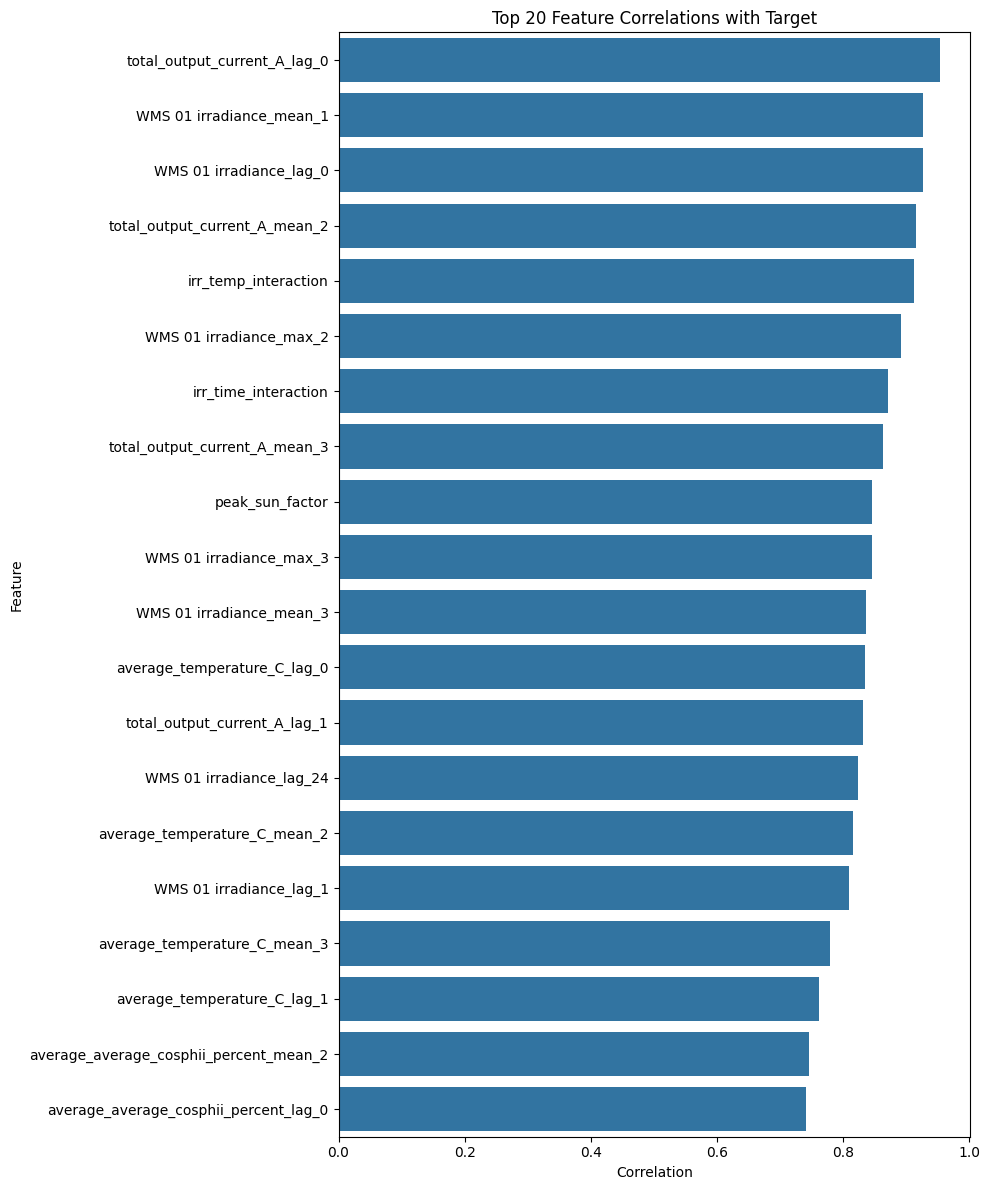

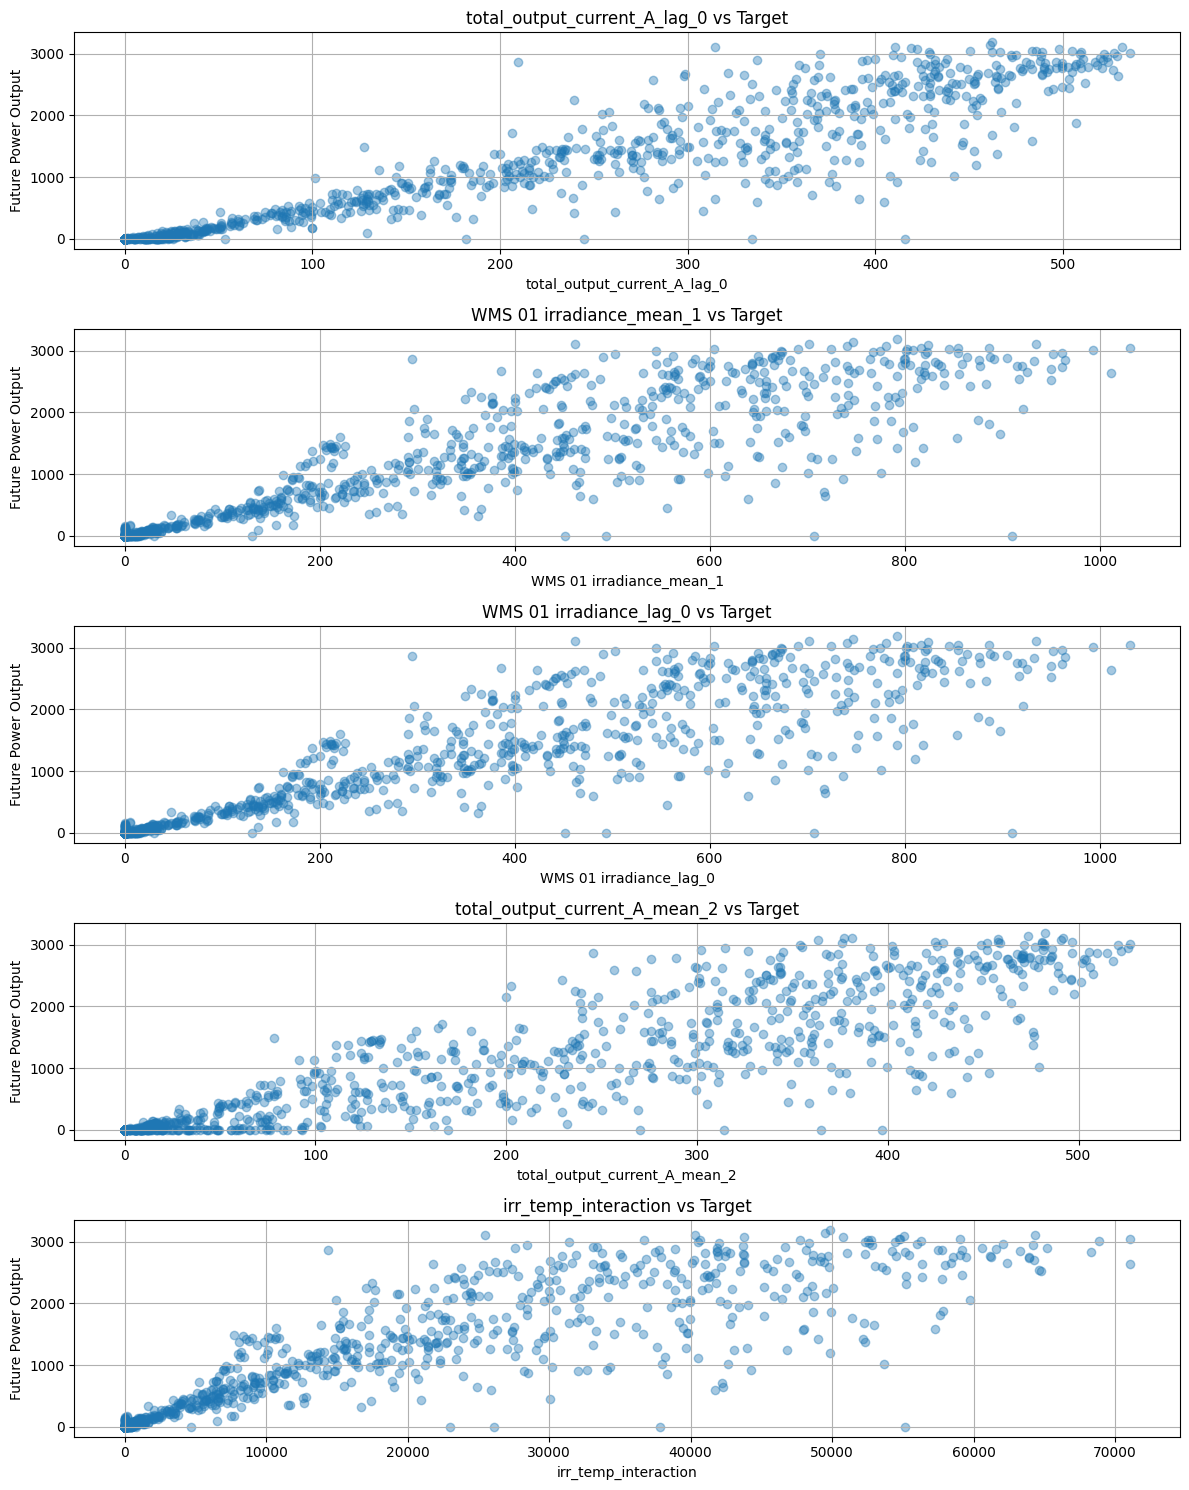


Step 3: Training model...


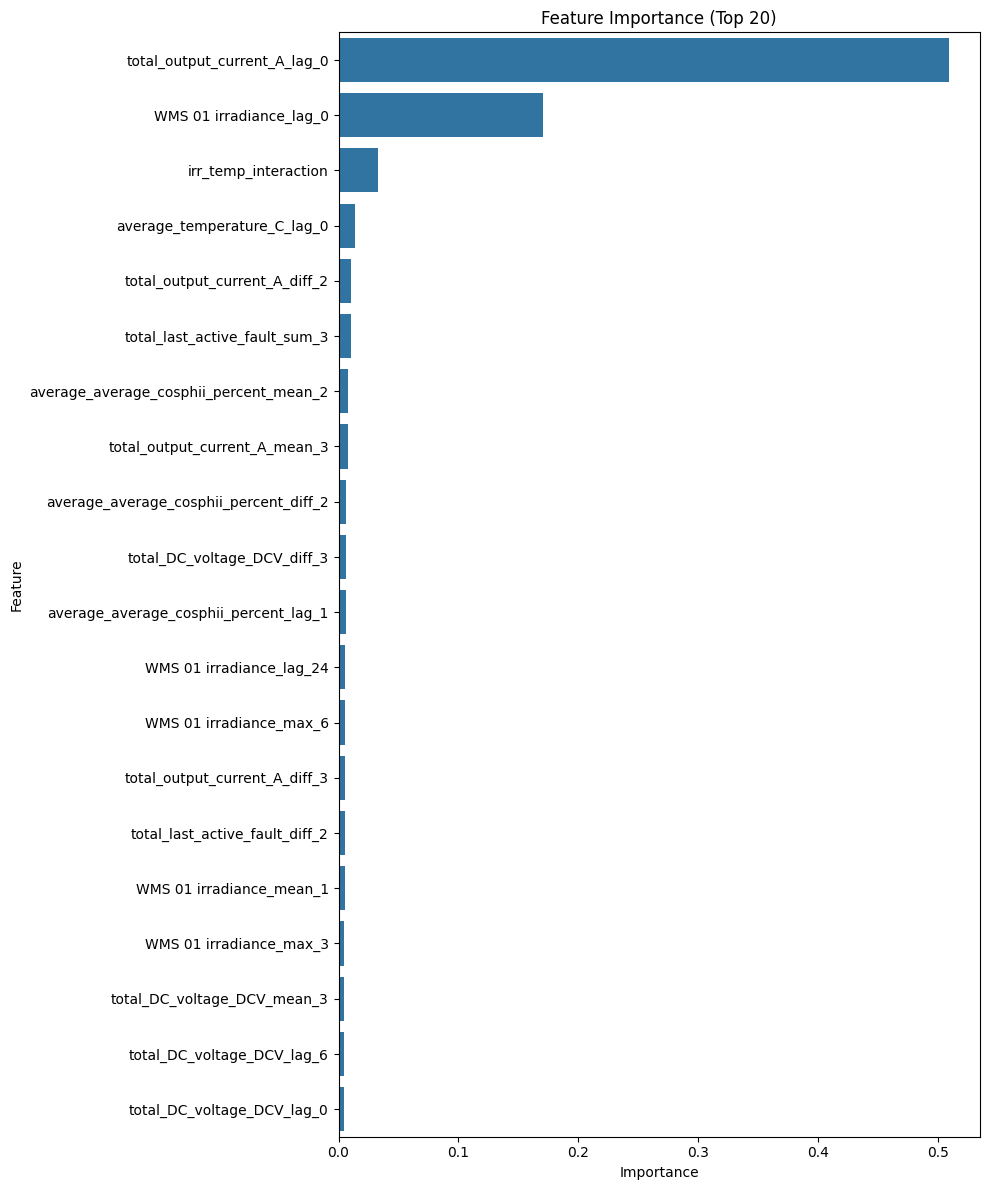


Step 4: Evaluating model...

Training Metrics:
RMSE: 13.9226
MAE: 7.4893
R2: 0.9998

Test Metrics:
RMSE: 284.8625
MAE: 139.1068
R2: 0.9164
NRMSE: 0.4011
NMAE: 0.1959

Step 5: Plotting results...


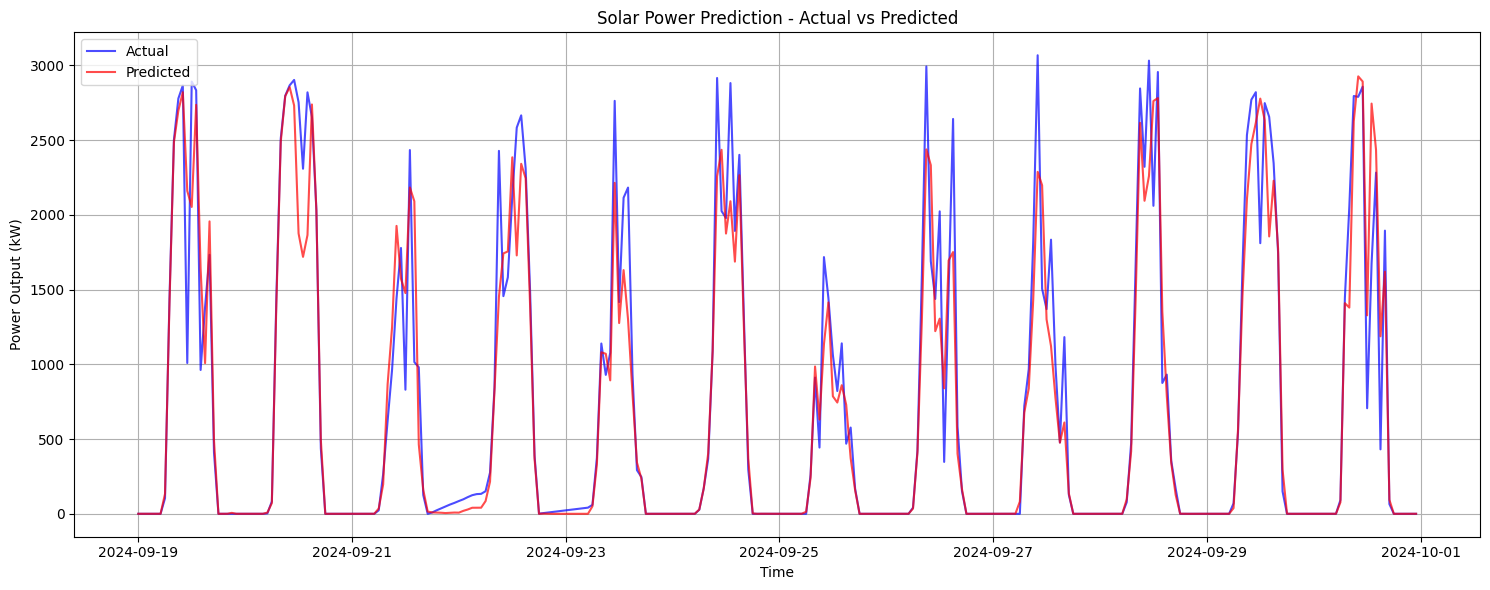

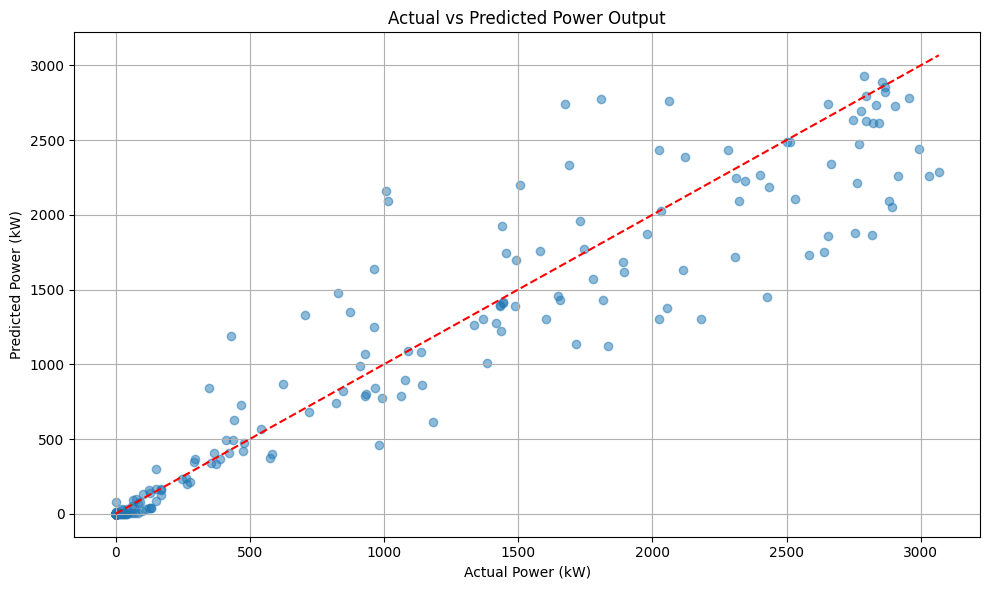

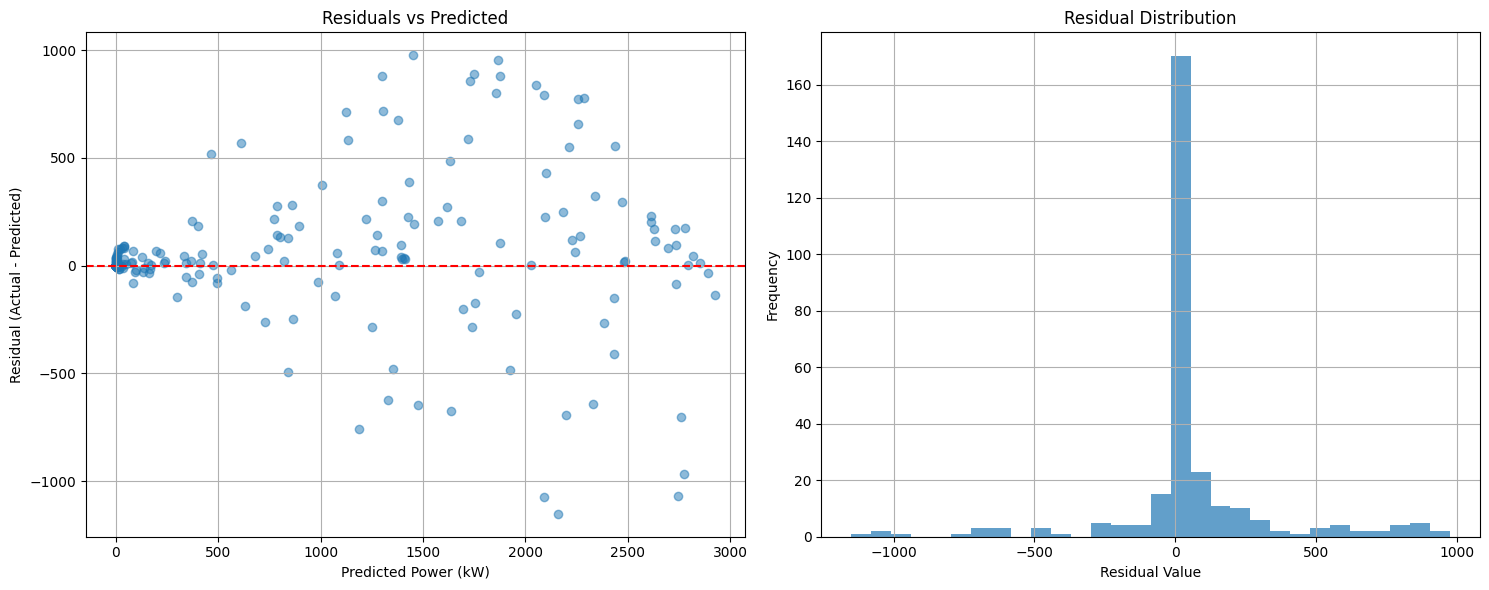

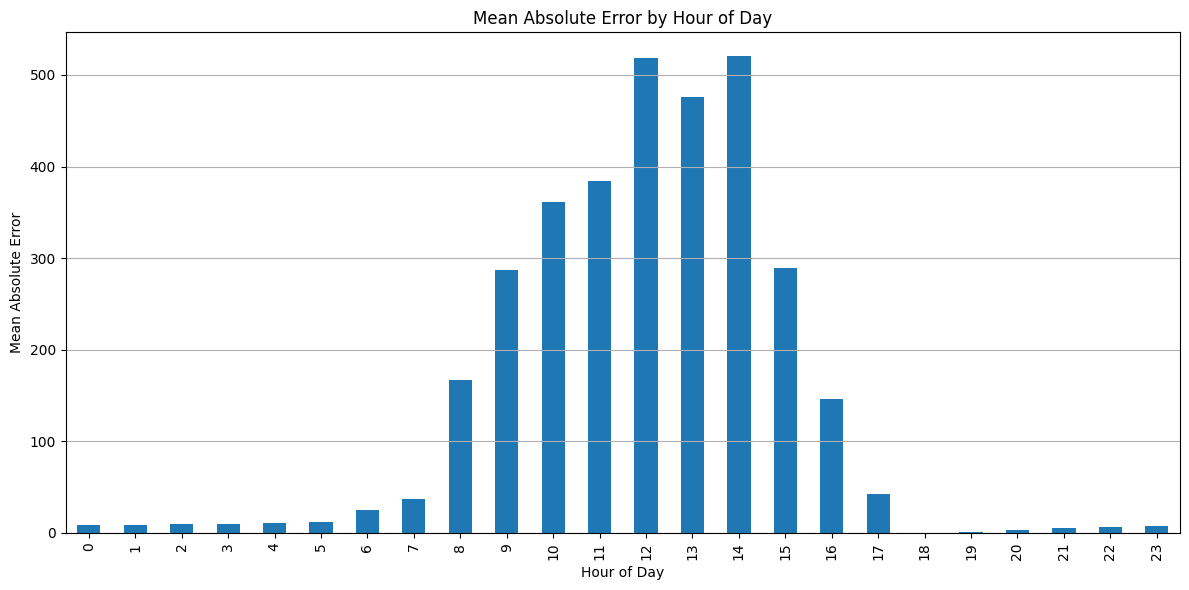

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import seaborn as sns

class ImprovedXGBoostModel:
    def __init__(self, data=None, file_path=None, direct_features=None):
        if data is not None:
            self.df = data.copy()
        elif file_path is not None:
            self.df = pd.read_csv(file_path)
        else:
            raise ValueError("Provide either a DataFrame or file path")

        # Allow user to specify which features to use directly
        #self.direct_features = direct_features or ['WMS 01 irradiancee']

        self.scaler = MinMaxScaler()
        self.model = None

        self.target = None

        # Starting with basic features
        self.features = []

        # Direct features to use (these are passed directly to the model without transformations)
        #self.direct_features = ['WMS 01 irradiance']

        # Define what features to engineer and how
        self.feature_engineering_plan = {
            'total_output_power_kW': {
                'lags': [0,1, 2, 3, 6, 12, 24],  # Expanded lag windows
                'rolling': {'mean': [3, 6, 12], 'std': [3,6], 'min': [3,6], 'max': [2,3,6]},
                'diff': [1, 2,3]  # Rate of change in power
            },
            'average_temperature_C': {
                'lags': [0,1, 3, 6, 12],
                'rolling': {'mean': [2,3, 6], 'std': [2,3,6]},
                'diff': [1, 2,3]  # Temperature change rate
            },
            'total_DC_voltage_DCV': {
                'lags': [0,1, 3, 6],
                'rolling': {'mean': [2,3, 6], 'std': [2,3,6]},
                'diff': [1, 2,3]  # Voltage change rate
            },
            'total_output_current_A': {
                'lags': [0,1, 3, 6],
                'rolling': {'mean': [2,3, 6], 'std': [2,3,6]},
                'diff': [1, 2,3]
            },
            'average_average_cosphii_percent': {
                'lags': [0,1, 3, 6],
                'rolling': {'mean': [2,3, 6]},
                'diff': [1, 2,3]
            },
            'total_time_run_today_h': {
                'lags': [0, 1, 3, 6],
                'rolling': {'sum': [3, 6]},
                'diff': [1, 2,3]
            },
            'total_last_active_fault': {
                'lags': [0, 1, 3],
                'rolling': {'sum': [3, 6]},
                'diff': [1, 2,3]
            }
        }

        # If solar irradiance is available, add it to plan
        if 'WMS 01 irradiance' in self.df.columns:
            self.feature_engineering_plan['WMS 01 irradiance'] = {
                'lags': [0, 1, 2, 3, 6, 12, 24],
                'rolling': {'mean': [1,3, 6, 12], 'std': [2,3,6], 'max': [2, 3,6]},
                'diff': [1, 2, 3]  # Rate of change in irradiance
            }

    def preprocess_data(self, target_horizon=3, resample_freq='60T'):
        """
        Preprocess data with more sophisticated feature engineering

        Parameters:
        - target_horizon: Number of periods ahead to predict
        - resample_freq: Frequency to resample data ('60T' for hourly)
        """
        # Parse datetime
        if 'datetime' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['datetime'])
            self.df.set_index('datetime', inplace=True)
        elif 'index' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['index'])
            self.df.set_index('datetime', inplace=True)
        else:
          # If no datetime column is found, try to infer from 'date' and 'time'
          try:
              self.df['datetime'] = pd.to_datetime(self.df['date'] + ' ' + self.df['time'])
              self.df.set_index('datetime', inplace=True)
          except KeyError:
              raise ValueError("No valid datetime information found. Please provide a 'datetime', 'date' and 'time', or 'index' column.")

        # Enhanced time-based features
        self.df['hour'] = self.df.index.hour
        self.df['day'] = self.df.index.day
        self.df['month'] = self.df.index.month
        self.df['dayofweek'] = self.df.index.dayofweek
        self.df['quarter'] = self.df.index.quarter
        self.df['minute'] = self.df.index.minute

        # Solar position-related features (improved)
        self.df['hours_since_sunrise'] = (self.df['hour'] + self.df['minute'] / 60 - 6).clip(lower=0)
        self.df['hours_until_sunset'] = (18 - (self.df['hour'] + self.df['minute'] / 60)).clip(lower=0)
        self.df['is_daytime'] = ((self.df['hour'] >= 6) & (self.df['hour'] < 18)).astype(int)

        # Peak sun hours approximation (simplified model)
        self.df['peak_sun_factor'] = np.sin(np.pi * (self.df['hour'] + self.df['minute']/60 - 6) / 12)
        self.df['peak_sun_factor'] = self.df['peak_sun_factor'].clip(lower=0)

        # Create cyclic time features to better capture periodicity
        self.df['hour_sin'] = np.sin(2 * np.pi * self.df['hour'] / 24)
        self.df['hour_cos'] = np.cos(2 * np.pi * self.df['hour'] / 24)
        self.df['month_sin'] = np.sin(2 * np.pi * self.df['month'] / 12)
        self.df['month_cos'] = np.cos(2 * np.pi * self.df['month'] / 12)

        # Resample to desired frequency
        # Step 1: Keep the original high-frequency target series
        original_target = self.df['total_output_power_kW'].copy()

        # Step 2: Resample all numeric feature columns except the target
        df_features = self.df.drop(columns=['total_output_power_kW'])
        df_resampled = df_features.select_dtypes(include=[np.number]).resample(resample_freq).mean()

        # Step 3: Rebuild target: get future values of original target aligned with the resampled timestamps
        future_target = original_target.shift(-target_horizon)
        df_resampled['power_future'] = future_target.resample(resample_freq).first()

        # Feature engineering based on plan
        for col, ops in self.feature_engineering_plan.items():
            if col not in df_resampled.columns:
                print(f"Warning: {col} not found in dataframe, skipping")
                continue

            # Create lag features
            if 'lags' in ops:
                for lag in ops['lags']:
                    feature_name = f'{col}_lag_{lag}'
                    df_resampled[feature_name] = df_resampled[col].shift(lag)
                    self.features.append(feature_name)

            # Create rolling window features
            if 'rolling' in ops:
                for method, windows in ops['rolling'].items():
                    for window in windows:
                        feature_name = f'{col}_{method}_{window}'
                        if method == 'mean':
                            df_resampled[feature_name] = df_resampled[col].rolling(window=window).mean()
                        elif method == 'sum':
                            df_resampled[feature_name] = df_resampled[col].rolling(window=window).sum()
                        elif method == 'std':
                            df_resampled[feature_name] = df_resampled[col].rolling(window=window).std()
                        elif method == 'min':
                            df_resampled[feature_name] = df_resampled[col].rolling(window=window).min()
                        elif method == 'max':
                            df_resampled[feature_name] = df_resampled[col].rolling(window=window).max()
                        self.features.append(feature_name)

            # Create difference features (rate of change)
            if 'diff' in ops:
                for periods in ops['diff']:
                    feature_name = f'{col}_diff_{periods}'
                    df_resampled[feature_name] = df_resampled[col].diff(periods=periods)
                    self.features.append(feature_name)

        # Add time features to feature list
        time_features = ['hour', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
                         'hours_since_sunrise', 'hours_until_sunset', 'is_daytime',
                         'peak_sun_factor']

        df_resampled[time_features] = self.df[time_features]
        self.features += time_features

        # Create interaction features if solar irradiance is available
        if 'WMS 01 irradiance' in df_resampled.columns:
            df_resampled['irr_temp_interaction'] = df_resampled['WMS 01 irradiance'] * df_resampled['average_temperature_C']
            df_resampled['irr_time_interaction'] = df_resampled['WMS 01 irradiance'] * df_resampled['peak_sun_factor']
            self.features += ['irr_temp_interaction', 'irr_time_interaction']

        # Create target (future power output)
        #df_resampled['power_future'] = df_resampled['total_output_power_kW'].shift(-target_horizon)

        # Drop rows with NaN values
        self.df_clean = df_resampled.dropna()

        # Add for later use in metaModel
        self.target = self.df_clean['power_future']

        # Add direct features if they exist in the dataframe
        # for feature in self.direct_features:
        #     if feature in df_resampled.columns:
        #         self.features.append(feature)
        #         print(f"Added direct feature: {feature}")

        # Print final feature list count
        print(f"Total features created: {len(self.features)}")

    def analyze_features(self):
        """Analyze feature importance and relationships"""
        X = self.df_clean[self.features]
        y = self.df_clean['power_future']

        # Correlation heatmap of top features with target
        corr = pd.DataFrame(X.corrwith(y).sort_values(ascending=False)).reset_index()
        corr.columns = ['Feature', 'Correlation']

        plt.figure(figsize=(10, 12))
        top_n = min(20, len(corr))
        sns.barplot(x='Correlation', y='Feature', data=corr.head(top_n))
        plt.title(f'Top {top_n} Feature Correlations with Target')
        plt.tight_layout()
        plt.show()

        # Plot relationship between top features and target
        top_features = corr.head(5)['Feature'].tolist()

        fig, axes = plt.subplots(len(top_features), 1, figsize=(12, 15))
        for i, feature in enumerate(top_features):
            axes[i].scatter(X[feature], y, alpha=0.4)
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Future Power Output')
            axes[i].set_title(f'{feature} vs Target')
            axes[i].grid(True)

        plt.tight_layout()
        plt.show()

        return corr

    def train_model(self, param_grid=None):
        """Train XGBoost model with improved grid search"""
        X = self.df_clean[self.features]
        y = self.df_clean['power_future']

        # Train-test split with stratified temporal split
        split_idx = int(len(self.df_clean) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test

        # Scale features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        # # Default param grid if none provided
        # if param_grid is None:
        #     param_grid = {
        #         'n_estimators': [100, 200, 300],
        #         'max_depth': [5, 7, 9],
        #         'learning_rate': [0.01, 0.05, 0.1],
        #         'subsample': [0.8, 0.9, 1.0],
        #         'colsample_bytree': [0.8, 0.9, 1.0],
        #         'min_child_weight': [1, 3, 5],
        #         'gamma': [0, 0.1, 0.2]
        #     }

        # # Grid search with cross-validation
        # grid = RandomizedSearchCV(
        #     XGBRegressor(objective='reg:squarederror', random_state=42),
        #     param_distributions=param_grid,
        #     n_iter=30,  # Try 20 random combinations
        #     cv=3,
        #     scoring='neg_mean_squared_error',
        #     verbose=1,
        #     n_jobs=-1
        # )

        # grid.fit(self.X_train_scaled, self.y_train)
        # self.model = grid.best_estimator_

        # print(f"Best parameters: {grid.best_params_}")

        default_params = {
            'n_estimators': 200,
            'max_depth': 7,
            'learning_rate': 0.05,
            'subsample': 0.9,
            'colsample_bytree': 0.9,
            'min_child_weight': 3,
            'gamma': 0.1,
            'objective': 'reg:squarederror',
            'random_state': 42
        }

        # Initialize and fit the model
        self.model = XGBRegressor(**default_params)
        self.model.fit(self.X_train_scaled, self.y_train)

        # Get feature importance
        feature_importance = pd.DataFrame({
            'Feature': self.features,
            'Importance': self.model.feature_importances_
        }).sort_values('Importance', ascending=False)

        plt.figure(figsize=(10, 12))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
        plt.title('Feature Importance (Top 20)')
        plt.tight_layout()
        plt.show()

        return feature_importance

    def evaluate_model(self):
        """Evaluate model with additional metrics"""
        # Make predictions
        y_pred_train = self.model.predict(self.X_train_scaled)
        y_pred_test = self.model.predict(self.X_test_scaled)

        # Clip negative predictions to zero
        y_pred_train = np.clip(y_pred_train, a_min=0, a_max=None)
        y_pred_test = np.clip(y_pred_test, a_min=0, a_max=None)

        # Calculate metrics
        train_metrics = {
            'rmse': np.sqrt(mean_squared_error(self.y_train, y_pred_train)),
            'mae': mean_absolute_error(self.y_train, y_pred_train),
            'r2': r2_score(self.y_train, y_pred_train)
        }

        test_metrics = {
            'rmse': np.sqrt(mean_squared_error(self.y_test, y_pred_test)),
            'mae': mean_absolute_error(self.y_test, y_pred_test),
            'r2': r2_score(self.y_test, y_pred_test)
        }

        # Calculate normalized metrics
        y_mean = self.y_test.mean()
        test_metrics['nrmse'] = test_metrics['rmse'] / y_mean
        test_metrics['nmae'] = test_metrics['mae'] / y_mean

        print("\nTraining Metrics:")
        for k, v in train_metrics.items():
            print(f"{k.upper()}: {v:.4f}")

        print("\nTest Metrics:")
        for k, v in test_metrics.items():
            print(f"{k.upper()}: {v:.4f}")

        self.metrics = test_metrics
        return train_metrics, test_metrics

    def plot_results(self):
        """Plot comprehensive evaluation results"""
        y_pred = self.model.predict(self.X_test_scaled)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)

        # Create a DataFrame with actual and predicted values
        results_df = pd.DataFrame({
            'Actual': self.y_test.values,
            'Predicted': y_pred
        }, index=self.y_test.index)

        # Plot actual vs predicted time series
        plt.figure(figsize=(15, 6))
        plt.plot(results_df.index, results_df['Actual'], label='Actual', color='blue', alpha=0.7)
        plt.plot(results_df.index, results_df['Predicted'], label='Predicted', color='red', alpha=0.7)
        plt.title('Solar Power Prediction - Actual vs Predicted')
        plt.ylabel('Power Output (kW)')
        plt.xlabel('Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot scatter of actual vs predicted
        plt.figure(figsize=(10, 6))
        plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)

        # Add perfect prediction line
        max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
        plt.plot([0, max_val], [0, max_val], 'r--')

        plt.title('Actual vs Predicted Power Output')
        plt.xlabel('Actual Power (kW)')
        plt.ylabel('Predicted Power (kW)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot residuals
        residuals = results_df['Actual'] - results_df['Predicted']
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(results_df['Predicted'], residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residuals vs Predicted')
        plt.xlabel('Predicted Power (kW)')
        plt.ylabel('Residual (Actual - Predicted)')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.hist(residuals, bins=30, alpha=0.7)
        plt.title('Residual Distribution')
        plt.xlabel('Residual Value')
        plt.ylabel('Frequency')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Plot predictions for a sample period (2 weeks)
        if len(results_df) > 14*24:  # If we have at least 2 weeks of data
            sample_period = results_df.iloc[-14*24:]  # Last 2 weeks

            plt.figure(figsize=(15, 6))
            plt.plot(sample_period.index, sample_period['Actual'], label='Actual', color='blue')
            plt.plot(sample_period.index, sample_period['Predicted'], label='Predicted', color='red')
            plt.title('2-Week Sample Period - Actual vs Predicted')
            plt.ylabel('Power Output (kW)')
            plt.xlabel('Time')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        # Display error over time of day
        results_df['hour'] = results_df.index.hour
        results_df['abs_error'] = abs(results_df['Actual'] - results_df['Predicted'])

        hour_error = results_df.groupby('hour')['abs_error'].mean()

        plt.figure(figsize=(12, 6))
        hour_error.plot(kind='bar')
        plt.title('Mean Absolute Error by Hour of Day')
        plt.xlabel('Hour of Day')
        plt.ylabel('Mean Absolute Error')
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

    def predict(self, data=None):
        """
        Predict on the full dataset (no train-test split).
        Useful when using this model as a feature generator for meta-models.

        Parameters:
        - data: optional, custom DataFrame to predict on.
                If None, will use self.df_clean from previous preprocessing.

        Returns:
        - predictions: np.array of predicted values
        - index: index of predictions (datetime or row index)
        """
        # if self.model is None:
        #     raise ValueError("Model has not been trained yet. Call `train_model()` first.")

        # if data is None:
        #     if not hasattr(self, 'df_clean'):
        #         raise ValueError("No preprocessed data available. Call `preprocess_data()` first.")
        #     X_full = self.df_clean[self.features]
        #     index = self.df_clean.index
        # else:
        #     # Use passed data (must already have matching features)
        #     missing = [feat for feat in self.features if feat not in data.columns]
        #     if missing:
        #         raise ValueError(f"Missing required features: {missing}")
        if data is None:
            data = self.df_clean

        X_full = data[self.features]
        index = data.index

        X_scaled = self.scaler.transform(X_full)
        predictions = self.model.predict(X_scaled)
        predictions = np.clip(predictions, a_min=0, a_max=None)

        return pd.Series(predictions, index=index, name="xgb_predictions")


    def test_for_leakage(self):
        """Leakage test: Train on shuffled targets and check performance"""

        # Shuffle the target values (break any true pattern)
        y_train_shuffled = np.random.permutation(self.y_train)

        # Train a new XGBoost model on the same features but with shuffled targets
        shuffled_model = XGBRegressor(objective='reg:squarederror', random_state=42)
        shuffled_model.fit(self.X_train_scaled, y_train_shuffled)

        # Predict on the test set
        y_pred_test = shuffled_model.predict(self.X_test_scaled)

        # Evaluate performance on real test targets
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred_test))
        mae = mean_absolute_error(self.y_test, y_pred_test)
        r2 = r2_score(self.y_test, y_pred_test)

        print("\n=== Leakage Detection Test ===")
        print("Model trained on SHUFFLED target values:")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"Test MAE: {mae:.4f}")
        print(f"Test R²: {r2:.4f}")

        if r2 > 0.2:
            print("⚠️ WARNING: Model is performing too well on shuffled data. Possible leakage!")
        else:
            print("✅ No obvious leakage detected.")

        return {'rmse': rmse, 'mae': mae, 'r2': r2}


    def run_pipeline(self, target_horizon=3, resample_freq='60T'):
        """Run the complete pipeline"""
        print("Step 1: Preprocessing data...")
        self.preprocess_data(target_horizon=target_horizon, resample_freq=resample_freq)

        print("\nStep 2: Analyzing features...")
        feature_corr = self.analyze_features()

        print("\nStep 3: Training model...")
        feature_importance = self.train_model()

        print("\nStep 4: Evaluating model...")
        train_metrics, test_metrics = self.evaluate_model()

        print("\nStep 5: Plotting results...")
        self.plot_results()

        return {
            'feature_correlation': feature_corr,
            'feature_importance': feature_importance,
            'metrics': test_metrics
        }

# Usage example
if __name__ == "__main__":
    # Example of how to use the model with solar irradiance as a direct feature

    # Option 1: Using default direct features (solar_irradiance)
    model = ImprovedXGBoostModel(data=df.reset_index())
    results = model.run_pipeline()
    # model.preprocess_data()
    # model.train_model()
    # model.test_for_leakage()
    # model.test_for_leakage()
    # # Option 2: Specify custom direct features
    # model = ImprovedXGBoostModel(
    #     file_path="your_solar_data.csv",
    #     direct_features=['solar_irradiance']
    # )
    # results = model.run_pipeline()

ok so i want to try meta-model (Stacking), residual learning, and bias correction on my LSTM and XGBoost models. if i show you the code can you help me with this? also my models are currently at different time resolutions. this was something i was trying and sometimes i have them at the same time resolution. so if you could it would be nice to be able to say what time resolution i want for what model


In [ ]:
df.columns

Index(['total_net_frequency_Hz', 'average_temperature_C',
       'total_yesterdays_energy_kWh', 'total_Accumulated Export Energy',
       'total_Export Energy', 'total_output_current_A',
       'total_output_power_kW', 'total_DC_voltage_DCV',
       'total_time_run_yesterday_h', 'total_grid_connections',
       'total_time_run_today_h', 'total_todays_energy_kWh',
       'total_net_AC_voltage_V', 'total_energy_counter_MWh',
       'total_time_run_total_h', 'total_last_active_fault',
       'average_average_cosphii_percent', 'WMS 01 ambient_temperature',
       'WMS 01 irradiance', 'WMS 01 wind_speed', 'hour'],
      dtype='object')

In [ ]:
'average_temperature_C', 'total_output_current_A','total_net_frequency_Hz', 'average_temperature_C',
                                     'total_output_current_A','total_output_power_kW', 'total_DC_voltage_DCV', 'total_net_AC_voltage_V','total_time_run_total_h', 'total_last_active_fault',
       'average_average_cosphii_percent'

In [14]:
60*3

180

# Do the meta thing

## original way

In [46]:
class MetaModelManager:
    def __init__(self, data, train_ratio=0.8, val_ratio=0.1, meta_ratio=0.1):
        self.data = data
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.meta_ratio = meta_ratio
        self.split_data()

    def split_data(self):
        total_len = len(self.data)
        train_end = int(self.train_ratio * total_len)
        val_end = train_end + int(self.val_ratio * total_len)

        self.base_train_data = self.data.iloc[:train_end]
        self.holdout_data = self.data.iloc[train_end:val_end]
        self.test_data = self.data.iloc[val_end:]

    def run_models(self, lstm_freq='60min', xgb_freq='1H', lstm_horizon=3, xgb_horizon=3):
        # === Train LSTM ===
        self.lstm_model = LSTMForecastModel(data=self.base_train_data)
        self.lstm_model.preprocess_data(resample_freq=lstm_freq, target_horizon=lstm_horizon)
        self.lstm_model.create_sequences()
        self.lstm_model.build_model()
        self.lstm_model.train_model()
        self.lstm_model.evaluate_model()

        # === LSTM Predictions ===
        self.lstm_holdout = self.lstm_model.predict(
            new_data=self.holdout_data,
            resample_freq=lstm_freq,
            target_horizon=lstm_horizon
        )

        self.y_lstm_test = self.lstm_model.predict(
            new_data=self.test_data,
            resample_freq=lstm_freq,
            target_horizon=lstm_horizon
        )

        # === Train XGBoost ===
        self.xgb_model = ImprovedXGBoostModel(data=self.base_train_data.reset_index())
        self.xgb_model.preprocess_data(resample_freq=xgb_freq, target_horizon=xgb_horizon)
        self.xgb_model.train_model()
        self.xgb_model.evaluate_model()

        # === XGBoost Predictions ===
        # Create a fresh model for holdout data
        xgb_holdout_model = ImprovedXGBoostModel(data=self.holdout_data.reset_index())
        # Preprocess the holdout data
        xgb_holdout_model.preprocess_data(resample_freq=xgb_freq, target_horizon=xgb_horizon)
        # Reuse the trained model and fitted scaler
        xgb_holdout_model.model = self.xgb_model.model
        xgb_holdout_model.scaler = self.xgb_model.scaler
        # Now make predictions
        self.xgb_holdout = xgb_holdout_model.predict(data=xgb_holdout_model.df_clean)

        # Create a fresh model instance for the test data
        xgb_test_model = ImprovedXGBoostModel(data=self.test_data.reset_index())
        # Preprocess the test data using the same horizon and frequency
        xgb_test_model.preprocess_data(resample_freq=xgb_freq, target_horizon=xgb_horizon)
        # Inject the trained model and fitted scaler from the original trained model
        xgb_test_model.model = self.xgb_model.model
        xgb_test_model.scaler = self.xgb_model.scaler
        # Predict using the test data
        self.xgb_test = xgb_test_model.predict(data=xgb_test_model.df_clean)


        # === Align predictions and true values on holdout ===
        y_true_holdout = xgb_holdout_model.target
        common_index = y_true_holdout.index.intersection(self.xgb_holdout.index).intersection(self.lstm_holdout.index)

        self.blend_df = pd.DataFrame({
            'y_true': y_true_holdout.loc[common_index],
            'lstm_pred': self.lstm_holdout.loc[common_index].values,
            'xgb_pred': self.xgb_holdout.loc[common_index].values
        }, index=common_index)


        # Align test set predictions for meta-model
        y_true_test = xgb_test_model.target
        common_test_index = y_true_test.index.intersection(self.y_lstm_test.index).intersection(self.xgb_test.index)

        X_meta = pd.DataFrame({
            'lstm_pred': self.y_lstm_test.loc[common_test_index].values,
            'xgb_pred': self.xgb_test.loc[common_test_index].values
        }, index=common_test_index)

        y_true_aligned = y_true_test.loc[common_test_index]

        self.X_meta_test = X_meta
        self.y_meta_true = y_true_aligned

    def train_meta_model(self):
        from sklearn.linear_model import Ridge

        X_blend = self.blend_df[['lstm_pred', 'xgb_pred']]
        y_blend = self.blend_df['y_true']

        self.meta_model = Ridge(alpha=1.0)
        self.meta_model.fit(X_blend, y_blend)

        # Align final test set inputs
        X_meta = self.X_meta_test[['lstm_pred', 'xgb_pred']]
        self.meta_model_pred = self.meta_model.predict(X_meta)

        return self.meta_model_pred

    def train_residual_model(self, residual_features):
        """
        Trains a model to predict the residual error from the meta-model.

        Parameters:
        - residual_features: DataFrame of features aligned with holdout set for residual modeling.
        """
        from xgboost import XGBRegressor

        # Calculate residuals
        residual_target = self.blend_df['y_true'] - self.meta_model.predict(self.blend_df[['lstm_pred', 'xgb_pred']])

        # Train residual model
        self.residual_model = XGBRegressor()
        self.residual_model.fit(residual_features.loc[self.blend_df.index], residual_target)

    def apply_residual_correction(self, test_features):
        """
        Applies residual correction on top of the meta-model predictions.

        Parameters:
        - test_features: DataFrame of features aligned with meta test set.

        Returns:
        - corrected_predictions: np.array of final corrected predictions.
        """
        residual_pred = self.residual_model.predict(test_features.loc[self.X_meta_test.index])
        corrected_preds = self.meta_model_pred + residual_pred
        self.meta_model_pred = corrected_preds  # overwrite if desired

        return corrected_preds


    def evaluate_meta_model(self, y_test_true):
        from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

        # Align actual with prediction index
        y_true = y_test_true.loc[self.X_meta_test.index]
        y_pred = self.meta_model_pred

        # Metrics
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)

        print(f"Meta-Model Evaluation:\nMAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")

        # Plot actual vs predicted
        plt.figure(figsize=(12, 6))
        plt.plot(y_true.index, y_true.values, label='Actual', linewidth=2)
        plt.plot(y_true.index, y_pred, label='Meta Predicted', linestyle='--')
        plt.title("Meta Model: Actual vs Predicted")
        plt.xlabel("Time")
        plt.ylabel("Power Output (kW)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return mae, rmse, r2

## New way

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

class MetaModelManager:
    def __init__(self, data, train_ratio=0.8, val_ratio=0.1, meta_ratio=0.1):
        self.data = data
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.meta_ratio = meta_ratio
        self.split_data()

    def split_data(self):
        total_len = len(self.data)
        train_end = int(self.train_ratio * total_len)
        val_end = train_end + int(self.val_ratio * total_len)

        self.base_train_data = self.data.iloc[:train_end]
        self.holdout_data = self.data.iloc[train_end:val_end]
        self.test_data = self.data.iloc[val_end:]

    def run_models(self, lstm_freq='10min', xgb_freq='1H', lstm_horizon=18, xgb_horizon=3):
        # === Train LSTM ===
        self.lstm_model = LSTMForecastModel(data=self.base_train_data)
        self.lstm_model.preprocess_data(resample_freq=lstm_freq, target_horizon=lstm_horizon)
        self.lstm_model.create_sequences()
        self.lstm_model.build_model()
        self.lstm_model.train_model()

        # === Predict LSTM on holdout and test ===
        self.y_lstm_holdout = pd.Series(
            self.lstm_model.predict(self.holdout_data),
            index=pd.date_range(start=self.holdout_data.index[self.lstm_model.lookback],
                                periods=len(self.holdout_data) - self.lstm_model.lookback,
                                freq=lstm_freq),
            name='lstm_pred'
        )
        self.y_lstm_test = pd.Series(
            self.lstm_model.predict(self.test_data),
            index=pd.date_range(start=self.test_data.index[self.lstm_model.lookback],
                                periods=len(self.test_data) - self.lstm_model.lookback,
                                freq=lstm_freq),
            name='lstm_pred'
        )

        # === Train XGBoost ===
        self.xgb_model = ImprovedXGBoostModel(data=self.base_train_data)
        self.xgb_model.preprocess_data(resample_freq=xgb_freq, target_horizon=xgb_horizon)
        self.xgb_model.train_model()

        # === Predict XGBoost on holdout and test ===
        xgb_holdout_model = ImprovedXGBoostModel(data=self.holdout_data)
        xgb_holdout_model.preprocess_data(resample_freq=xgb_freq, target_horizon=xgb_horizon)
        self.xgb_holdout = xgb_holdout_model.predict(data=xgb_holdout_model.df_clean)

        xgb_test_model = ImprovedXGBoostModel(data=self.test_data)
        xgb_test_model.preprocess_data(resample_freq=xgb_freq, target_horizon=xgb_horizon)
        self.xgb_test = xgb_test_model.predict(data=xgb_test_model.df_clean)

        # Store features for residual/bias correction
        self.residual_train_feats = xgb_holdout_model.df_clean[xgb_holdout_model.features]
        self.residual_test_feats = xgb_test_model.df_clean[xgb_test_model.features]

        # Lightweight features for bias correction (example subset)
        self.bias_train_feats = self.residual_train_feats[['hour', 'dayofweek', 'peak_sun_factor']]
        self.bias_test_feats = self.residual_test_feats[['hour', 'dayofweek', 'peak_sun_factor']]

        # === Align predictions and build blend_df ===
        common_index = self.xgb_holdout.index.intersection(self.y_lstm_holdout.index)
        self.blend_df = pd.DataFrame({
            'y_true': self.holdout_data.loc[common_index, 'total_output_power_kW'],
            'lstm_pred': self.y_lstm_holdout.loc[common_index].values,
            'xgb_pred': self.xgb_holdout.loc[common_index].values
        }, index=common_index)

        # Align test predictions
        test_common_index = self.y_lstm_test.index.intersection(self.xgb_test.index)
        self.X_meta_test = pd.DataFrame({
            'lstm_pred': self.y_lstm_test.loc[test_common_index].values,
            'xgb_pred': self.xgb_test.loc[test_common_index].values
        }, index=test_common_index)
        self.y_test_true = self.test_data.loc[test_common_index, 'total_output_power_kW']

    def train_meta_model(self):
        X_blend = self.blend_df[['lstm_pred', 'xgb_pred']]
        y_blend = self.blend_df['y_true']

        self.meta_model = Ridge(alpha=1.0)
        self.meta_model.fit(X_blend, y_blend)
        self.meta_model_pred = self.meta_model.predict(self.X_meta_test)

    def train_residual_model(self):
        residual_target = self.blend_df['y_true'] - self.meta_model.predict(self.blend_df[['lstm_pred', 'xgb_pred']])
        self.residual_model = XGBRegressor()
        self.residual_model.fit(self.residual_train_feats.loc[self.blend_df.index], residual_target)

    def apply_residual_correction(self):
        residual_pred = self.residual_model.predict(self.residual_test_feats.loc[self.X_meta_test.index])
        self.meta_model_pred += residual_pred

    def train_bias_model(self):
        bias_target = self.blend_df['y_true'] - self.meta_model.predict(self.blend_df[['lstm_pred', 'xgb_pred']])
        self.bias_model = LinearRegression()
        self.bias_model.fit(self.bias_train_feats.loc[self.blend_df.index], bias_target)

    def apply_bias_correction(self):
        bias_pred = self.bias_model.predict(self.bias_test_feats.loc[self.X_meta_test.index])
        self.meta_model_pred += bias_pred

    def evaluate_meta_model(self, prediction_stage="final"):
        y_true = self.y_test_true.loc[self.X_meta_test.index]

        if prediction_stage == "meta_only":
            y_pred = self.meta_only_pred
        elif prediction_stage == "meta_plus_residual":
            y_pred = self.meta_plus_residual_pred
        elif prediction_stage == "meta_plus_residual_bias":
            y_pred = self.meta_plus_residual_bias_pred
        else:
            y_pred = self.meta_model_pred  # final prediction

        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)

        print(f"Evaluation ({prediction_stage}): MAE={mae:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(y_true.index, y_true.values, label='Actual', linewidth=2)
        plt.plot(y_true.index, y_pred, label=prediction_stage.replace("_", " ").title(), linestyle='--')
        plt.title(f"Actual vs {prediction_stage.replace('_', ' ').title()}")
        plt.xlabel("Time")
        plt.ylabel("Power Output (kW)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return mae, rmse, r2



## New way 2 lol

In [65]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

class MetaModelManager:
    def __init__(self, data, train_ratio=0.8, val_ratio=0.1, meta_ratio=0.1):
        self.data = data
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.meta_ratio = meta_ratio
        self.split_data()

    def split_data(self):
        total_len = len(self.data)
        train_end = int(self.train_ratio * total_len)
        val_end = train_end + int(self.val_ratio * total_len)

        self.base_train_data = self.data.iloc[:train_end]
        self.holdout_data = self.data.iloc[train_end:val_end]
        self.test_data = self.data.iloc[val_end:]

    def run_models(self, lstm_freq='60min', xgb_freq='1H', lstm_horizon=3, xgb_horizon=3):
        # === Train LSTM ===
        self.lstm_model = LSTMForecastModel(data=self.base_train_data)
        self.lstm_model.preprocess_data(resample_freq=lstm_freq, target_horizon=lstm_horizon)
        self.lstm_model.create_sequences()
        self.lstm_model.build_model()
        self.lstm_model.train_model()

        # === LSTM Predictions ===
        self.y_lstm_holdout = pd.Series(self.lstm_model.predict(self.holdout_data), name='lstm_pred')
        self.y_lstm_test = pd.Series(self.lstm_model.predict(self.test_data), name='lstm_pred')

        # === Train XGBoost ===
        self.xgb_model = ImprovedXGBoostModel(data=self.base_train_data)
        self.xgb_model.preprocess_data(resample_freq=xgb_freq, target_horizon=xgb_horizon)
        self.xgb_model.train_model()

        # === XGBoost Predictions ===
        self.xgb_model.df = self.holdout_data.copy()
        self.xgb_model.preprocess_data(resample_freq=xgb_freq, target_horizon=xgb_horizon)
        self.xgb_holdout = self.xgb_model.predict(data=self.xgb_model.df_clean)

        self.xgb_model.df = self.test_data.copy()
        self.xgb_model.preprocess_data(resample_freq=xgb_freq, target_horizon=xgb_horizon)
        self.xgb_test = self.xgb_model.predict(data=self.xgb_model.df_clean)

        # === Align predictions on holdout set ===
        common_index = self.xgb_holdout.index.intersection(self.y_lstm_holdout.index)

        self.blend_df = pd.DataFrame({
            'y_true': self.holdout_data.loc[common_index, 'total_output_power_kW'],
            'lstm_pred': self.y_lstm_holdout.loc[common_index].values,
            'xgb_pred': self.xgb_holdout.loc[common_index].values
        }, index=common_index)

        # === Align test predictions ===
        common_test_index = self.y_lstm_test.index.intersection(self.xgb_test.index)
        self.X_meta_test = pd.DataFrame({
            'lstm_pred': self.y_lstm_test.loc[common_test_index].values,
            'xgb_pred': self.xgb_test.loc[common_test_index].values
        }, index=common_test_index)

    def train_meta_model(self):
        print("Training meta-model...")
        X_blend = self.blend_df[['lstm_pred', 'xgb_pred']]
        y_blend = self.blend_df['y_true']

        self.meta_model = Ridge(alpha=1.0)
        self.meta_model.fit(X_blend, y_blend)

        self.meta_model_pred = self.meta_model.predict(self.X_meta_test)
        print("Meta-model training complete.")

    def train_residual_model(self):
        print("Training residual model...")

        # Get residual target
        y_blend_pred = self.meta_model.predict(self.blend_df[['lstm_pred', 'xgb_pred']])
        residual_target = self.blend_df['y_true'] - y_blend_pred

        # Get residual features from XGBoost pipeline (already preprocessed)
        residual_features_df = self.xgb_holdout_model.df_clean[self.xgb_model.features]
        residual_features_df = residual_features_df.loc[self.blend_df.index]

        self.residual_model = XGBRegressor()
        self.residual_model.fit(residual_features_df, residual_target)

        print("Residual model training complete.")

    def apply_residual_correction(self):
        print("Applying residual correction...")

        test_features_df = self.xgb_test_model.df_clean[self.xgb_model.features]
        test_features_df = test_features_df.loc[self.X_meta_test.index]

        residual_pred = self.residual_model.predict(test_features_df)
        self.meta_model_pred = self.meta_model_pred + residual_pred

        print("Residual correction applied.")
        return self.meta_model_pred

    def evaluate_meta_model(self, y_test_true):
        print("Evaluating meta-model...")
        y_true = y_test_true.loc[self.X_meta_test.index]
        y_pred = self.meta_model_pred

        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)

        print(f"Meta-Model Evaluation:\nMAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(y_true.index, y_true.values, label='Actual', linewidth=2)
        plt.plot(y_true.index, y_pred, label='Meta Predicted', linestyle='--')
        plt.title("Meta Model: Actual vs Predicted")
        plt.xlabel("Time")
        plt.ylabel("Power Output (kW)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return mae, rmse, r2


Epoch 1/50


<ipython-input-45-791011b62b5e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_clean[self.features] = self.scaler.fit_transform(self.df_clean[self.features])


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1185308.0000 - mae: 622.0439 - val_loss: 1947924.2500 - val_mae: 878.0557
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1251716.6250 - mae: 653.5930 - val_loss: 1887283.8750 - val_mae: 874.8277
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1084731.3750 - mae: 627.7863 - val_loss: 1818253.5000 - val_mae: 873.0239
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1131175.5000 - mae: 655.7262 - val_loss: 1741075.1250 - val_mae: 874.8546
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 981174.6250 - mae: 620.9906 - val_loss: 1659767.5000 - val_mae: 879.7086
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1001313.6875 - mae: 655.6550 - val_loss: 1581140.2500 - val_mae: 886.2045
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 925827.2500 - mae: 662.7944 - val_loss: 1511919.6250 - val_mae: 893.0159
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 849473.3750 - mae: 657.0636 - 

<ipython-input-67-faff4f3d21a4>:134: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df_features.select_dtypes(include=[np.number]).resample(resample_freq).mean()
<ipython-input-67-faff4f3d21a4>:138: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled['power_future'] = future_target.resample(resample_freq).first()
<ipython-input-67-faff4f3d21a4>:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['irr_time_interaction'] = df_resampled['WMS 01 irradiance'] * df_resampled['peak_sun_factor']


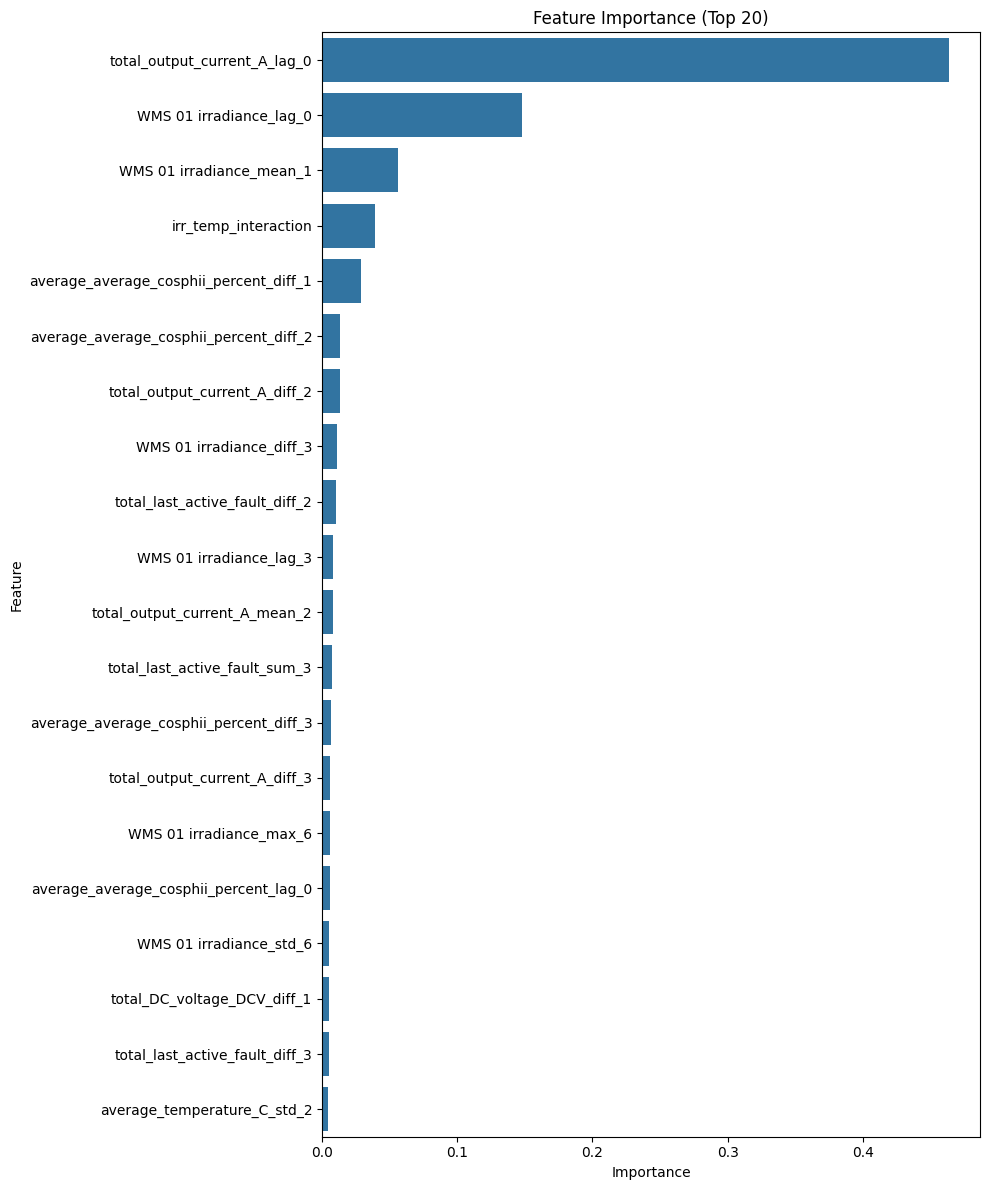

Total features created: 196


<ipython-input-67-faff4f3d21a4>:134: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df_features.select_dtypes(include=[np.number]).resample(resample_freq).mean()
<ipython-input-67-faff4f3d21a4>:138: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled['power_future'] = future_target.resample(resample_freq).first()
<ipython-input-67-faff4f3d21a4>:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['irr_time_interaction'] = df_resampled['WMS 01 irradiance'] * df_resampled['peak_sun_factor']


ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [68]:
# This is for new way 2

# Step 1: Initialize manager
manager = MetaModelManager(data=df.reset_index())

# Step 2: Train base models and get predictions
manager.run_models()

# Step 3: Train meta-model on holdout predictions
manager.train_meta_model()

# Step 4: Train residual model on meta-model residuals
manager.train_residual_model()

# Step 5: Apply correction on test set
manager.apply_residual_correction()

# Step 6: Evaluate final corrected predictions
manager.evaluate_meta_model(y_test_true=manager.test_data['total_output_power_kW'])


Epoch 1/50


<ipython-input-45-791011b62b5e>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_clean[self.features] = self.scaler.fit_transform(self.df_clean[self.features])


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1251505.0000 - mae: 646.2164 - val_loss: 1950919.0000 - val_mae: 878.2700
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1217981.1250 - mae: 644.7773 - val_loss: 1909168.8750 - val_mae: 875.8403
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1070411.0000 - mae: 599.8647 - val_loss: 1856470.3750 - val_mae: 873.7411
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1127872.8750 - mae: 650.5780 - val_loss: 1794245.5000 - val_mae: 873.1732
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1108968.0000 - mae: 656.4792 - val_loss: 1726746.5000 - val_mae: 875.4811
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1121425.7500 - mae: 678.3242 - val_loss: 1652068.3750 - val_mae: 880.3282
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1135880.1250 - mae: 716.1578 - val_loss: 1580123.6250 - val_mae: 886.3159
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1039829.0625 - mae: 705.

<ipython-input-43-e1974e6475bb>:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['irr_time_interaction'] = df_resampled['WMS 01 irradiance'] * df_resampled['peak_sun_factor']


Best parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}


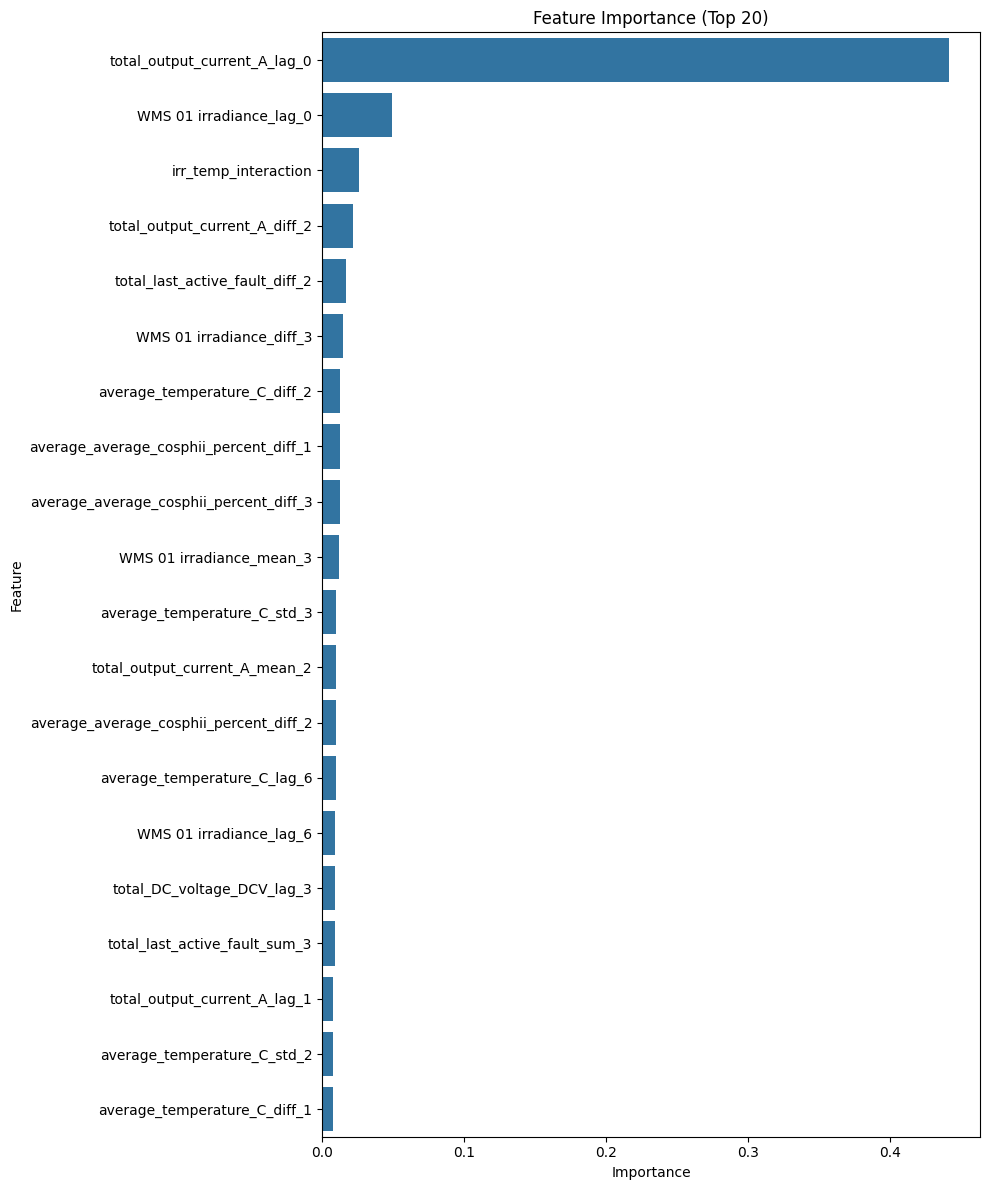


Training Metrics:
RMSE: 62.0411
MAE: 29.6489
R2: 0.9953

Test Metrics:
RMSE: 386.6798
MAE: 188.6969
R2: 0.8768
NRMSE: 0.4352
NMAE: 0.2124
Total features created: 98
Total features created: 98


<ipython-input-43-e1974e6475bb>:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['irr_time_interaction'] = df_resampled['WMS 01 irradiance'] * df_resampled['peak_sun_factor']
<ipython-input-43-e1974e6475bb>:188: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['irr_time_interaction'] = df_resampled['WMS 01 irradiance'] * df_resampled['peak_sun_factor']


In [47]:
# this is how to run the original way
meta = MetaModelManager(df)
meta.run_models(lstm_freq='60min', xgb_freq='60min', lstm_horizon=3, xgb_horizon=3)

Meta-Model Evaluation:
MAE: 165.732 | RMSE: 321.393 | R²: 0.899


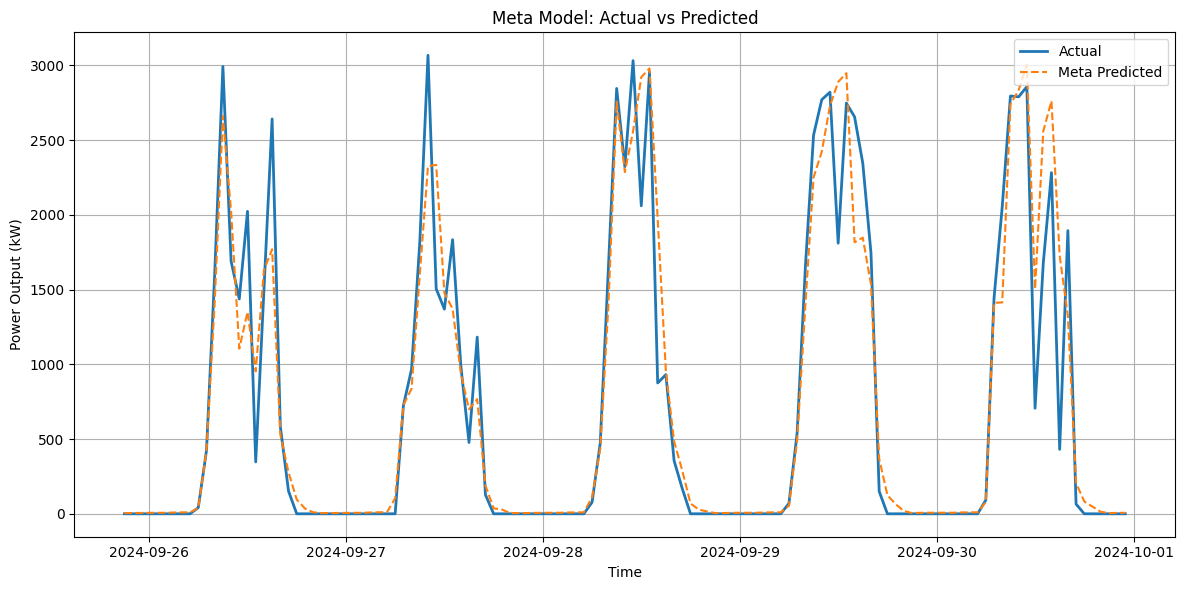

(165.73187199879467, np.float64(321.3932864010495), 0.8989738413072725)

In [48]:
meta.train_meta_model()
meta.evaluate_meta_model(meta.y_meta_true)

In [54]:
# 4. Add residual correction and evaluate
meta.train_residual_model()
meta.meta_plus_residual_pred = meta.meta_only_pred + meta.residual_model.predict(
    meta.residual_test_feats.loc[meta.X_meta_test.index]
)
meta.evaluate_meta_model(prediction_stage="meta_plus_residual")

TypeError: MetaModelManager.train_residual_model() missing 1 required positional argument: 'residual_features'

### both of these were trained at 1 hour time interval
performance on the meta model is better than just XGBoost

MAE: 167.570 | RMSE: 325.800 | R²: 0.896


MAE: 170.391 | RMSE: 321.425 | R²: 0.899


im not really sure how this makes any sense, but I took out irradiance from the direct features in the XGBoost class and i got these score:
MAE: 178.236 | RMSE: 338.600 | R²: 0.888

and this one:

MAE: 165.732 | RMSE: 321.393 | R²: 0.899

# Results

# this is old code

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

class XGBoostModel:
    def __init__(self, data=None, file_path=None):
        if data is not None:
            self.df = data.copy()
        elif file_path is not None:
            self.df = pd.read_csv(file_path)
        else:
            raise ValueError("Provide either a DataFrame or file path")

        self.scaler = MinMaxScaler()
        self.model = None  # Will be set after grid search
        self.features = ['WMS 01 irradiance','hours_since_sunrise','hours_until_sunset', 'is_daytime']

        # Define what features to engineer and how
        self.feature_engineering_plan = {
            'total_output_power_kW': {'lags': [3, 6], 'rolling': {'mean': [3, 6]}},
            'average_temperature_C': {'lags': [3, 6], 'rolling': {'mean': [3]}},
           'total_DC_voltage_DCV':{'lags': [3, 6], 'rolling': {'mean': [3, 6]}},
            'total_output_current_A': {'lags': [3, 6], 'rolling': {'mean': [3, 6]}},
            'average_average_cosphii_percent': {'lags': [3, 6], 'rolling': {'mean': [3, 6]}},
            'total_time_run_today_h': {'lags': [3, 6], 'rolling': {'sum': [3, 6]}},
            'total_last_active_fault': {'lags': [3], 'rolling': {'sum': [3]}}
        }

    def preprocess_data(self):
        # Parse datetime
        if 'datetime' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['datetime'])
            self.df.set_index('datetime', inplace=True)
        elif 'index' in self.df.columns:
            self.df['datetime'] = pd.to_datetime(self.df['index'])
            self.df.set_index('datetime', inplace=True)

        self.df['hour'] = self.df.index.hour
        self.df['minute'] = self.df.index.minute

        self.df['hours_since_sunrise'] = (self.df['hour'] + self.df['minute'] / 60 - 5).clip(lower=0)
        self.df['hours_until_sunset'] = (19 - (self.df['hour'] + self.df['minute'] / 60)).clip(lower=0)
        self.df['is_daytime'] = ((self.df['hour'] >= 5) & (self.df['hour'] < 19)).astype(int)

        # Resample to hourly mean
        df_hourly = self.df #self.df.resample('90T').mean()

        # Feature engineering
        for col, ops in self.feature_engineering_plan.items():
            if 'lags' in ops:
                for lag in ops['lags']:
                    feature_name = f'{col}_lag_{lag}'
                    df_hourly[feature_name] = df_hourly[col].shift(lag)
                    self.features.append(feature_name)
            if 'rolling' in ops:
                for method, windows in ops['rolling'].items():
                    for window in windows:
                        feature_name = f'{col}_{method}_{window}'
                        if method == 'mean':
                            df_hourly[feature_name] = df_hourly[col].rolling(window=window).mean()
                        elif method == 'sum':
                            df_hourly[feature_name] = df_hourly[col].rolling(window=window).sum()
                        self.features.append(feature_name)

        # Add time-based features
        time_features = ['hour', 'hours_since_sunrise', 'hours_until_sunset', 'is_daytime']
        df_hourly[time_features] = self.df[time_features]
        self.features += time_features

        # Create target (3-hour ahead forecast)
        df_hourly['power_future'] = df_hourly['total_output_power_kW'].shift(-1)

        # Final clean dataset
        self.df_clean = df_hourly.dropna()

    def train_model(self):
        print(self.features)
        X = self.df_clean[self.features]
        y = self.df_clean['power_future']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        self.X_train, self.X_test = X_train, X_test
        self.y_train, self.y_test = y_train, y_test

        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        param_grid = {
            'n_estimators': [100, 150, 200],         # Number of trees
            'max_depth': [3, 5, 7],                # Tree depth
            'learning_rate': [0.05, 0.1],       # Learning rate
            'subsample': [0.8, 1.0],            # Sample rate per tree
            'colsample_bytree': [0.8, 1.0]      # Feature sample rate per tree
        }



        grid = GridSearchCV(
            XGBRegressor(objective='reg:squarederror', random_state=42),
            param_grid,
            cv=3,
            scoring='neg_mean_squared_error',
            verbose=1,
            n_jobs=-1
        )

        grid.fit(self.X_train_scaled, self.y_train)
        self.model = grid.best_estimator_

    def evaluate_model(self):
        y_pred = self.model.predict(self.X_test_scaled)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)

        self.metrics = {
            'rmse': np.sqrt(mean_squared_error(self.y_test, y_pred)),
            'mae': mean_absolute_error(self.y_test, y_pred),
            'r2': r2_score(self.y_test, y_pred)
        }

        return self.metrics

    def plot_results(self):
        y_pred = self.model.predict(self.X_test_scaled)
        y_pred = np.clip(y_pred, a_min=0, a_max=None)

        plt.figure(figsize=(12, 6))
        plt.plot(self.y_test.index, self.y_test.values, label='Actual')
        plt.plot(self.y_test.index, y_pred, label='Predicted')
        plt.title('3-Hour Ahead Solar Power Prediction')
        plt.ylabel('Power Output (kW)')
        plt.xlabel('Time')
        plt.legend()
        plt.grid(True)
        plt.show()

        residuals = self.y_test - y_pred
        plt.figure(figsize=(12, 6))
        plt.scatter(y_pred, residuals, alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Residuals vs Predicted')
        plt.xlabel('Predicted')
        plt.ylabel('Residual')
        plt.grid(True)
        plt.show()

    def run_pipeline(self):
        self.preprocess_data()
        self.train_model()
        results = self.evaluate_model()
        self.plot_results()
        return results

boost = XGBoostModel(data=df)
boost.run_pipeline()


Step 1: Creating features...
Step 2: Training model with grid search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:
{'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
Step 3: Evaluating model and visualizing results...

RMSE: 468.8744
MAE: 334.5064
R2 Score: 0.7671


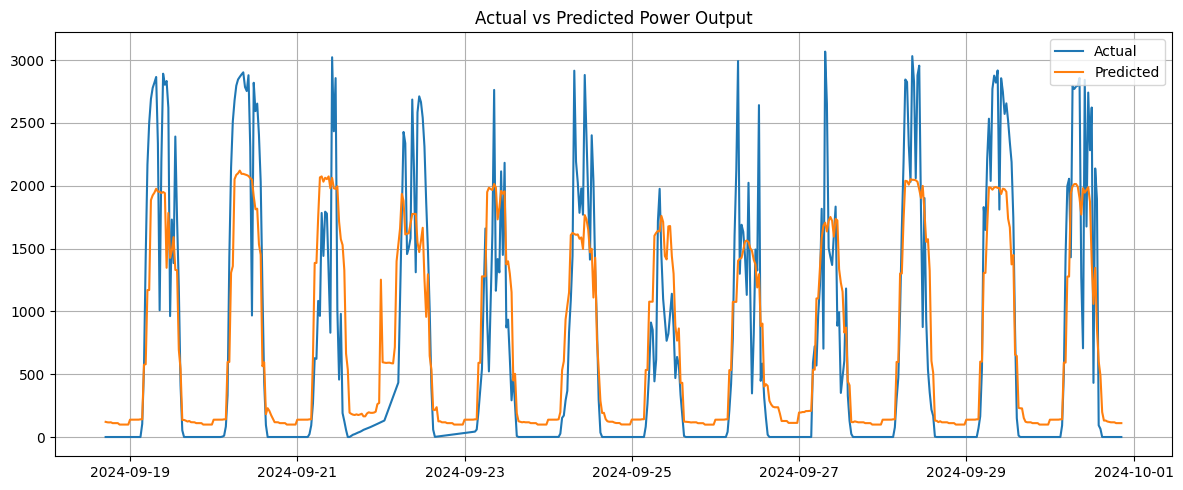

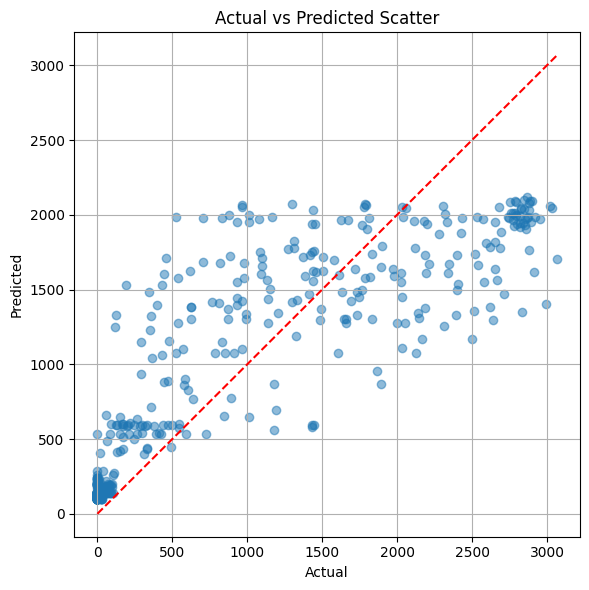

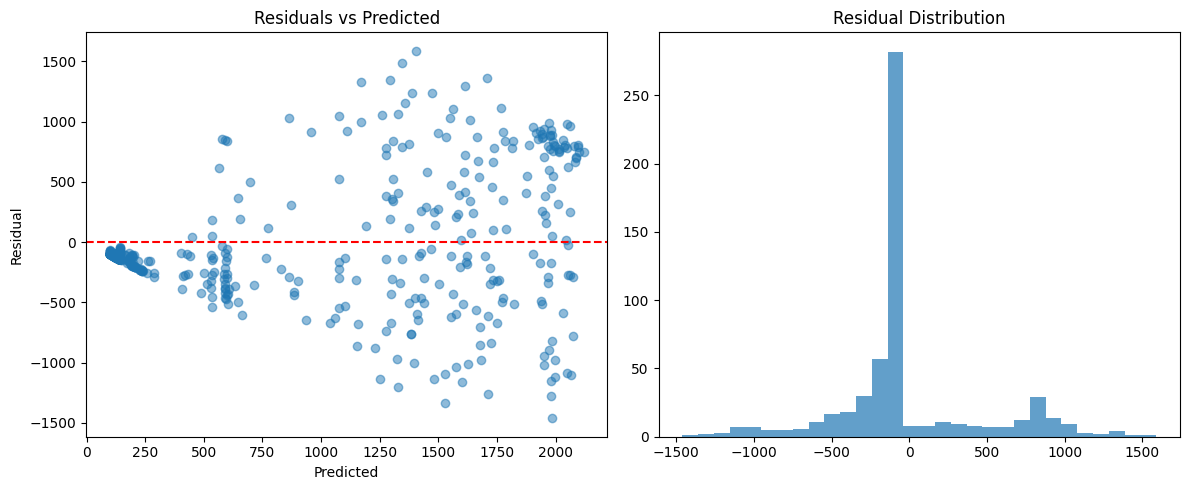

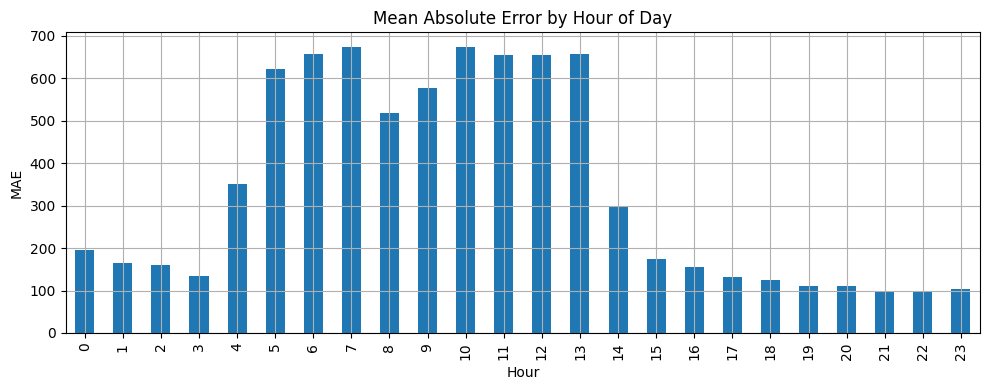

In [ ]:
# Prepare your dataframe
df = df.reset_index()
df = df.rename(columns={'index': 'datetime'})
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# Initialize the model
model = SimpleForecastingModel(
    df,
    horizon_steps=6,  # 3 hours ahead if data is every 10 mins
    direct_features=['WMS 01 irradiance'],  # available at prediction time
)

# Run the full pipeline
model.run()